## SME: BJ goods and competitive banks with reserve requirement

## System of equations

Given $\gamma=1+\tau$ and $i_r$

**Money demand**

$$
\frac{\gamma}{\beta}=1+\mathcal{R}(z,\mathbf{s})
$$

where the return on real money balance, $\mathcal{R}(z,\mathbf{s})$, is defined as:

$$
\mathcal{R}(z,\mathbf{s}) = 
\begin{cases}
    \int_{\underline{\rho}}^{\overline{\rho}} \left[ \frac{u_{q}[q(z,\rho,\mathbf{s})]}{\rho} - 1 \right] \varrho(\rho,z,\mathbf{s}) \, \text{d}J(\rho,z,\mathbf{s}) & \text{if } i = i_{d} \\
    \\
    \begin{aligned}
        & (1-n)i_{d} + n \int_{\underline{\rho}}^{\tilde{\rho}_{i}} i \cdot \varrho(\rho,z,\mathbf{s}) \, \text{d}J(\rho,z,\mathbf{s}) \\
        & + n \int_{\tilde{\rho}_{i}}^{\hat{\rho}_{i_{d}}} \left\{ \sum_{\ell=1}^{2}\omega_{\ell}(\rho,z,\mathbf{s}) \cdot \left[ \left( \frac{u_{q}(z/\rho_{\ell,\rho})}{\rho_{\ell,\rho}} \right) \mathbf{1}_{\{\rho_{\ell,\rho}\in(\tilde{\rho}_{i},\hat{\rho}_{i_{d}}]\}} - 1 \right] \right\} \varrho(\rho,z,\mathbf{s}) \, \text{d}J(\rho,z,\mathbf{s}) \\
        & + n \int_{\hat{\rho}_{i_{d}}}^{\overline{\rho}} i_{d} \cdot \varrho(\rho,z,\mathbf{s}) \, \text{d}J(\rho,z,\mathbf{s})
    \end{aligned} & \text{if } i > i_{d}
\end{cases}
$$

and where $\varrho(\rho,z,\mathbf{s}) := \alpha_{1}+2\alpha_{2}(1-J(\rho,z,\mathbf{s}))$, and

$$
\omega_{\ell}(\rho,z,\mathbf{s}) := \left(\mathbf{1}_{\{ L(\rho)\neq\emptyset \}} \cdot \pi_{\ell,\rho}\right) + \mathbf{1}_{\{ L(\rho)=\emptyset \text{ and } \rho_{\ell,\rho}=\rho \}}
$$
for $\ell \in \{1, 2\}$, where $\rho \sim J(\cdot,z,\mathbf{s})$.

**Loan Market Clearing**

Given $z=z^{\star}=Z, i=\bar{i}_{r}=i_{}^{\star}$ clears the loan market,

$$
\underbrace{ (1-\chi\cdot\mathbf{1}_{\{ i>i_{d}>i_{r}\} }) \left[ (1-n)z + n\int_{\underline{\rho}_{i}}^{\overline{\rho}}\delta^{\star}(\rho,i_{d},z)\,\text{d}\hat{J}(\rho,z,\mathbf{s}) \right] }_{=:D(\bar{i}_{r}), \text{ total deposits}} = \underbrace{ n\int_{\underline{\rho}}^{\tilde{\rho}_{i}}\xi^{\star}(\rho,i,z)\,\text{d}\hat{J}(\rho,z,\mathbf{s}) }_{=:L(\bar{i}_{r}), \text{ total loans}}
$$

## SME Welfare Decomposition
- This Jupyter notebook presents the results of welfare decomposition by buyer type in the SME.
- The results correspond to Figure 3: The Effects of Inflation on Equilibrium Outcomes.

### Calibrated parameters
* $(\sigma_{DM}, \bar{U}_{CM}) = (0.28, 1.8)$
* $\alpha_{1} = 0.05$
* $\alpha_{2} = 1-\alpha_{1}$        

In [1]:
import bj_bcw as main
import hlmw as hlmw
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'

In [3]:
σ_DM=0.283
Ubar_CM=1.8000
n=0.65
α_1=0.05
β=0.981
τ_min=β-1
τ_max = 0.1
τgrid_size = 60

In [4]:
model = main.baseline_mod(β=β,σ_DM=σ_DM, Ubar_CM=Ubar_CM, n=n,τ_max = τ_max,α_1=α_1,τgrid_size = τgrid_size,τ_min=τ_min,i_r=0,chi=0.007,N_reimann = 1000)

model_hlmw =hlmw.hlmw_mod(β=β,σ_DM=σ_DM, Ubar_CM=Ubar_CM, n=n,τ_max = τ_max,α_1=α_1,τgrid_size = τgrid_size,τ_min=τ_min,N_reimann = 1000)

In [5]:
def Total_q_func_credit(z, i, τ):
    """KLLN allocation: credit buyers with lottery probability weighting"""
    ρ_grid = model.support_grid_func(z, i, τ)
    
    ρ_tilde = model.ρ_tilde_func(z, i)
    ρ_tilde_index = np.argmax(ρ_grid >= ρ_tilde)
    ρ_grid_credit = ρ_grid[:ρ_tilde_index]
    
    if len(ρ_grid_credit) == 0:
        return 0.0
    
    pdf_grid = model.dF_normalization_func(z, i, τ)
    em_func = model.α_1 + 2.0*model.α_2*( 1.0 - model.F_func(i, z, τ) ) 
    em = em_func[:ρ_tilde_index]
    
    # Get lottery information
    ρ_range = model.support_grid_func(z, i, τ)
    Rex = model.R_ex(ρ_range, i, z)
    R_grid, R_fit, lottery_supports, lottery_payoffs = model.R(ρ_range, Rex)
    
    # Calculate expected quantity with lottery weighting
    q_expost_weighted = np.zeros_like(ρ_grid_credit)
    
    for j, ρ in enumerate(ρ_grid_credit):
        π1, π2 = model.get_lottery_probabilities(ρ, lottery_supports, lottery_payoffs, R_fit)
        
        if np.abs(π1) != 1.0:  # Lottery case
            # Find lottery segment prices
            ρ1, ρ2 = ρ, ρ  # Default
            for k in range(lottery_supports.shape[0]):
                if lottery_supports[k, 0] <= ρ <= lottery_supports[k, 1]:
                    ρ1, ρ2 = lottery_supports[k, :]
                    break
            
            # Expected quantity: π1×q(ρ1) + π2×q(ρ2)
            q1 = model.q_demand_func(ρ1, i, z)
            q2 = model.q_demand_func(ρ2, i, z)
            q_expost_weighted[j] = π1 * q1 + π2 * q2
        else:  # No lottery case
            q_expost_weighted[j] = model.q_demand_func(ρ, i, z)
    
    integrand_values = em * q_expost_weighted * pdf_grid[:ρ_tilde_index]
    total_q_credit = model.n * np.trapz(integrand_values, ρ_grid_credit)
    
    return total_q_credit

In [6]:
def Total_q_func_money_c(z, i, τ):
    """KLLN allocation: money constrained buyers with lottery probability weighting"""
    ρ_grid = model.support_grid_func(z, i, τ)
    
    ρ_tilde = model.ρ_tilde_func(z, i)
    ρ_hat = model.ρ_hat_id_func(z, i)
    
    ρ_tilde_index = np.argmax(ρ_grid > ρ_tilde)
    ρ_hat_index = np.argmax(ρ_grid >= ρ_hat)
    
    ρ_grid_money = ρ_grid[ρ_tilde_index:ρ_hat_index]
    
    if len(ρ_grid_money) == 0:
        return 0.0
    
    pdf_grid_full = model.dF_normalization_func(z, i, τ)
    pdf_grid = pdf_grid_full[ρ_tilde_index:ρ_hat_index]
    
    em_func = model.α_1 + 2.0*model.α_2*( 1.0 - model.F_func(i, z, τ) )
    em = em_func[ρ_tilde_index:ρ_hat_index]
    
    # Get lottery information
    ρ_range = model.support_grid_func(z, i, τ)
    Rex = model.R_ex(ρ_range, i, z)
    R_grid, R_fit, lottery_supports, lottery_payoffs = model.R(ρ_range, Rex)
    
    # Calculate expected quantity with lottery weighting
    q_expost_weighted = np.zeros_like(ρ_grid_money)
    
    for j, ρ in enumerate(ρ_grid_money):
        π1, π2 = model.get_lottery_probabilities(ρ, lottery_supports, lottery_payoffs, R_fit)
        
        if np.abs(π1) != 1.0:  # Lottery case
            # Find lottery segment prices
            ρ1, ρ2 = ρ, ρ  # Default
            for k in range(lottery_supports.shape[0]):
                if lottery_supports[k, 0] <= ρ <= lottery_supports[k, 1]:
                    ρ1, ρ2 = lottery_supports[k, :]
                    break
            
            # Expected quantity: π1×q(ρ1) + π2×q(ρ2)
            q1 = model.q_demand_func(ρ1, i, z)
            q2 = model.q_demand_func(ρ2, i, z)
            q_expost_weighted[j] = π1 * q1 + π2 * q2
        else:  # No lottery case
            q_expost_weighted[j] = model.q_demand_func(ρ, i, z)
    
    integrand_values = em * q_expost_weighted * pdf_grid
    total_q_money_c = model.n * np.trapz(integrand_values, ρ_grid_money)
    
    return total_q_money_c

In [7]:
def Total_q_func_money_uc(z, i, τ):
    """KLLN allocation: money unconstrained buyers with lottery probability weighting"""
    ρ_grid = model.support_grid_func(z, i, τ)
    ρ_hat = model.ρ_hat_id_func(z, i)
    ρ_hat_index = np.argmax(ρ_grid >= ρ_hat)
    
    ρ_grid_money_uc = ρ_grid[ρ_hat_index:]
    
    if len(ρ_grid_money_uc) == 0:
        return 0.0
    
    pdf_grid_full = model.dF_normalization_func(z, i, τ)
    pdf_grid = pdf_grid_full[ρ_hat_index:]
    
    em_func = model.α_1 + 2.0*model.α_2*( 1.0 - model.F_func(i, z, τ) )
    em = em_func[ρ_hat_index:]
    
    # Get lottery information
    ρ_range = model.support_grid_func(z, i, τ)
    Rex = model.R_ex(ρ_range, i, z)
    R_grid, R_fit, lottery_supports, lottery_payoffs = model.R(ρ_range, Rex)
    
    # Calculate expected quantity with lottery weighting
    q_expost_weighted = np.zeros_like(ρ_grid_money_uc)
    
    for j, ρ in enumerate(ρ_grid_money_uc):
        π1, π2 = model.get_lottery_probabilities(ρ, lottery_supports, lottery_payoffs, R_fit)
        
        if np.abs(π1) != 1.0:  # Lottery case
            # Find lottery segment prices
            ρ1, ρ2 = ρ, ρ  # Default
            for k in range(lottery_supports.shape[0]):
                if lottery_supports[k, 0] <= ρ <= lottery_supports[k, 1]:
                    ρ1, ρ2 = lottery_supports[k, :]
                    break
            
            # Expected quantity: π1×q(ρ1) + π2×q(ρ2)
            q1 = model.q_demand_func(ρ1, i, z)
            q2 = model.q_demand_func(ρ2, i, z)
            q_expost_weighted[j] = π1 * q1 + π2 * q2
        else:  # No lottery case
            q_expost_weighted[j] = model.q_demand_func(ρ, i, z)
    
    integrand_values = em * q_expost_weighted * pdf_grid
    total_q_money_uc = model.n * np.trapz(integrand_values, ρ_grid_money_uc)
    
    return total_q_money_uc

### DM net trading surplus

#### Credit + own money:  $\rho \in [\underline{\rho}(z), \tilde{\rho}_{i}(z)]$

$$
\int^{\tilde{\rho}_{i}(z)}_{\underline{\rho}(z)} \left[ u\left(q_{b}(\rho,i,z)\right) - c\left(q_{b}(\rho,i,z)\right) \right]\, \mathrm{d}\hat{J}(\rho,z)
$$


#### Own money constrained: $\rho \in (\tilde{\rho}_{i}(z), \hat{\rho}_{id}(z))$
$$
\int^{\hat{\rho}_{id}(z)}_{\tilde{\rho}_{i}(z)} \left[ u\left(q_{b}(\rho,i,z)\right) - c\left(q_{b}(\rho,i,z)\right) \right] \, \mathrm{d}\hat{J}(\rho,z)
$$


#### Own money unconstrained: $\rho \in [\hat{\rho}_{id}(z), \overline{\rho}(z)]$
$$
\int^{\overline{\rho}(z)}_{\hat{\rho}_{id}(z)} \left[ u\left(q_{b}(\rho,i,z)\right) - c\left(q_{b}(\rho,i,z)\right) \right] \, \mathrm{d}\hat{J}(\rho,z)
$$


where
$$
        q_{b}\left(\rho, i, z \right)
        =
        \begin{cases}
          \left[\rho \left(1+i\right)\right]^{-1/\sigma}
          &
          \text{if } 0< \rho \leq \tilde{\rho}_{i}
          \\
          \frac{z}{\rho}
          &
          \text{if }\tilde{\rho}_{i} < \rho < \hat{\rho}_{id}
          \\
          [\rho(1+i_d)]^{-1/\sigma}
          &
          \text{if } \rho \geq \hat{\rho}_{id}
        \end{cases}.
        %\label{eq:Demand q-ss}
 $$
 
 Likewise, for HLMW

In [8]:
def surplus_credit_func(z, i, τ):
    """KLLN DM trading surplus: credit buyers with lottery probability weighting"""
    ρ_grid = model.support_grid_func(z, i, τ)
    
    ρ_tilde = model.ρ_tilde_func(z, i)
    ρ_tilde_index = np.argmax(ρ_grid >= ρ_tilde)
    ρ_grid_credit = ρ_grid[:ρ_tilde_index]
    
    if len(ρ_grid_credit) == 0:
        return 0.0
    
    pdf_grid = model.dF_normalization_func(z, i, τ)
    em_func = model.α_1 + 2.0*model.α_2*( 1.0 - model.F_func(i, z, τ) ) 
    em = em_func[:ρ_tilde_index]
    
    # Get lottery information
    ρ_range = model.support_grid_func(z, i, τ)
    Rex = model.R_ex(ρ_range, i, z)
    R_grid, R_fit, lottery_supports, lottery_payoffs = model.R(ρ_range, Rex)
    
    # Calculate expected surplus with lottery weighting
    net_q_expost_weighted = np.zeros_like(ρ_grid_credit)
    
    for j, ρ in enumerate(ρ_grid_credit):
        π1, π2 = model.get_lottery_probabilities(ρ, lottery_supports, lottery_payoffs, R_fit)
        
        if np.abs(π1) != 1.0:  # Lottery case
            # Find lottery segment prices
            ρ1, ρ2 = ρ, ρ  # Default
            for k in range(lottery_supports.shape[0]):
                if lottery_supports[k, 0] <= ρ <= lottery_supports[k, 1]:
                    ρ1, ρ2 = lottery_supports[k, :]
                    break
            
            # Expected surplus: π1×[u(q1) - c(q1)] + π2×[u(q2) - c(q2)]
            surplus1 = model.u_DM(model.q_demand_func(ρ1, i, z)) - model.cost_DM(model.q_demand_func(ρ1, i, z))
            surplus2 = model.u_DM(model.q_demand_func(ρ2, i, z)) - model.cost_DM(model.q_demand_func(ρ2, i, z))
            net_q_expost_weighted[j] = π1 * surplus1 + π2 * surplus2
        else:  # No lottery case
            net_q_expost_weighted[j] = model.u_DM(model.q_demand_func(ρ, i, z)) - model.cost_DM(model.q_demand_func(ρ, i, z))
    
    integrand_values = em * net_q_expost_weighted * pdf_grid[:ρ_tilde_index]
    surplus = model.n * np.trapz(integrand_values, ρ_grid_credit)
    
    return surplus

In [9]:
def surplus_money_c_func(z, i, τ):
    """KLLN DM trading surplus: money constrained buyers with lottery probability weighting"""
    ρ_grid = model.support_grid_func(z, i, τ)
    
    ρ_tilde = model.ρ_tilde_func(z, i)
    ρ_hat = model.ρ_hat_id_func(z, i)
    ρ_tilde_index = np.argmax(ρ_grid > ρ_tilde)
    ρ_hat_index = np.argmax(ρ_grid >= ρ_hat)
    
    ρ_grid_money = ρ_grid[ρ_tilde_index:ρ_hat_index]
    
    if len(ρ_grid_money) == 0:
        return 0.0
    
    pdf_grid_full = model.dF_normalization_func(z, i, τ)
    pdf_grid = pdf_grid_full[ρ_tilde_index:ρ_hat_index]
    
    em_func = model.α_1 + 2.0*model.α_2*( 1.0 - model.F_func(i, z, τ) )
    em = em_func[ρ_tilde_index:ρ_hat_index]
    
    # Get lottery information
    ρ_range = model.support_grid_func(z, i, τ)
    Rex = model.R_ex(ρ_range, i, z)
    R_grid, R_fit, lottery_supports, lottery_payoffs = model.R(ρ_range, Rex)
    
    # Calculate expected surplus with lottery weighting
    net_q_expost_weighted = np.zeros_like(ρ_grid_money)
    
    for j, ρ in enumerate(ρ_grid_money):
        π1, π2 = model.get_lottery_probabilities(ρ, lottery_supports, lottery_payoffs, R_fit)
        
        if np.abs(π1) != 1.0:  # Lottery case
            # Find lottery segment prices
            ρ1, ρ2 = ρ, ρ  # Default
            for k in range(lottery_supports.shape[0]):
                if lottery_supports[k, 0] <= ρ <= lottery_supports[k, 1]:
                    ρ1, ρ2 = lottery_supports[k, :]
                    break
            
            # Expected surplus: π1×[u(q1) - c(q1)] + π2×[u(q2) - c(q2)]
            surplus1 = model.u_DM(model.q_demand_func(ρ1, i, z)) - model.cost_DM(model.q_demand_func(ρ1, i, z))
            surplus2 = model.u_DM(model.q_demand_func(ρ2, i, z)) - model.cost_DM(model.q_demand_func(ρ2, i, z))
            net_q_expost_weighted[j] = π1 * surplus1 + π2 * surplus2
        else:  # No lottery case
            net_q_expost_weighted[j] = model.u_DM(model.q_demand_func(ρ, i, z)) - model.cost_DM(model.q_demand_func(ρ, i, z))
    
    integrand_values = em * net_q_expost_weighted * pdf_grid
    surplus_money_c = model.n * np.trapz(integrand_values, ρ_grid_money)
    
    return surplus_money_c

In [10]:
def surplus_money_uc_func(z, i, τ):
    """KLLN DM trading surplus: money unconstrained buyers with lottery probability weighting"""
    ρ_grid = model.support_grid_func(z, i, τ)
    ρ_hat = model.ρ_hat_id_func(z, i)
    ρ_hat_index = np.argmax(ρ_grid >= ρ_hat)
    
    ρ_grid_money_uc = ρ_grid[ρ_hat_index:]
    
    if len(ρ_grid_money_uc) == 0:
        return 0.0
    
    pdf_grid_full = model.dF_normalization_func(z, i, τ)
    pdf_grid = pdf_grid_full[ρ_hat_index:]
    
    em_func = model.α_1 + 2.0*model.α_2*( 1.0 - model.F_func(i, z, τ) )
    em = em_func[ρ_hat_index:]
    
    # Get lottery information
    ρ_range = model.support_grid_func(z, i, τ)
    Rex = model.R_ex(ρ_range, i, z)
    R_grid, R_fit, lottery_supports, lottery_payoffs = model.R(ρ_range, Rex)
    
    # Calculate expected surplus with lottery weighting
    net_q_expost_weighted = np.zeros_like(ρ_grid_money_uc)
    
    for j, ρ in enumerate(ρ_grid_money_uc):
        π1, π2 = model.get_lottery_probabilities(ρ, lottery_supports, lottery_payoffs, R_fit)
        
        if np.abs(π1) != 1.0:  # Lottery case
            # Find lottery segment prices
            ρ1, ρ2 = ρ, ρ  # Default
            for k in range(lottery_supports.shape[0]):
                if lottery_supports[k, 0] <= ρ <= lottery_supports[k, 1]:
                    ρ1, ρ2 = lottery_supports[k, :]
                    break
            
            # Expected surplus: π1×[u(q1) - c(q1)] + π2×[u(q2) - c(q2)]
            surplus1 = model.u_DM(model.q_demand_func(ρ1, i, z)) - model.cost_DM(model.q_demand_func(ρ1, i, z))
            surplus2 = model.u_DM(model.q_demand_func(ρ2, i, z)) - model.cost_DM(model.q_demand_func(ρ2, i, z))
            net_q_expost_weighted[j] = π1 * surplus1 + π2 * surplus2
        else:  # No lottery case
            net_q_expost_weighted[j] = model.u_DM(model.q_demand_func(ρ, i, z)) - model.cost_DM(model.q_demand_func(ρ, i, z))
    
    integrand_values = em * net_q_expost_weighted * pdf_grid
    surplus_money_uc = model.n * np.trapz(integrand_values, ρ_grid_money_uc)
    
    return surplus_money_uc

### HLMW: allocation

In [11]:
def Total_q_c_func_hlmw(z, τ):
    """HLMW allcoation: money constrained buyers"""
    ρ_grid = model_hlmw.support_grid_func(z, τ)
    
    ρ_hat = model_hlmw.ρ_hat_func(z)    

    ρ_hat_index = np.argmax(ρ_grid >= ρ_hat)
    
    ρ_grid_money = ρ_grid[:ρ_hat_index]
    
    pdf_grid_full = model_hlmw.dF_normalization_func(z, τ)
    
    pdf_grid = pdf_grid_full[:ρ_hat_index]

    em_func = model_hlmw.α_1 + 2.0*model_hlmw.α_2*( 1.0 - model_hlmw.F_func(z,τ) ) 
            
    em = em_func[:ρ_hat_index]
        
    q_expost = np.array( [model_hlmw.q_demand_func(ρ, z) for ρ in ρ_grid_money] )
        
    integrand_values = em * q_expost * pdf_grid
        
    total_q_c = model_hlmw.n*np.trapz(integrand_values, ρ_grid_money)
        
    return total_q_c

In [12]:
def Total_q_uc_func_hlmw(z, τ):
    """HLMW allcoation: money unconstrained buyers"""
    ρ_grid = model_hlmw.support_grid_func(z, τ)
    
    ρ_hat = model_hlmw.ρ_hat_func(z)    

    ρ_hat_index = np.argmax(ρ_grid >= ρ_hat)
    
    ρ_grid_money_uc = ρ_grid[ρ_hat_index:]
    
    pdf_grid_full = model_hlmw.dF_normalization_func(z, τ)
    
    pdf_grid = pdf_grid_full[ρ_hat_index:]

    em_func = model_hlmw.α_1 + 2.0*model_hlmw.α_2*( 1.0 - model_hlmw.F_func(z,τ) ) 
            
    em = em_func[ρ_hat_index:]
        
    q_expost = np.array( [model_hlmw.q_demand_func(ρ, z) for ρ in ρ_grid_money_uc] )
        
    integrand_values = em * q_expost * pdf_grid
        
    total_q_uc = model_hlmw.n*np.trapz(integrand_values, ρ_grid_money_uc)
        
    return total_q_uc

### HLMW: DM net trading surplus

In [13]:
def surplus_money_c_func_hlmw(z, τ):
    """HLMW DM surplus: money constrained buyers"""
    ρ_grid = model_hlmw.support_grid_func(z, τ)
    
    ρ_hat = model_hlmw.ρ_hat_func(z)
    
    ρ_hat_index = np.argmax(ρ_grid >= ρ_hat)
    
    ρ_grid_money = ρ_grid[:ρ_hat_index]
    
    pdf_grid_full = model_hlmw.dF_normalization_func(z, τ)
    
    pdf_grid = pdf_grid_full[:ρ_hat_index]

    em_func = model_hlmw.α_1 + 2.0*model_hlmw.α_2*( 1.0 - model_hlmw.F_func(z,τ) ) 
            
    em = em_func[:ρ_hat_index]
        
    net_q_expost = np.array( [model_hlmw.u_DM(model_hlmw.q_demand_func(ρ, z)) -\
                          model_hlmw.cost_DM(model_hlmw.q_demand_func(ρ, z)) for ρ in ρ_grid_money] )
        
    integrand_values = em * net_q_expost * pdf_grid
        
    surplus_c = model_hlmw.n*np.trapz(integrand_values, ρ_grid_money)
        
    return surplus_c

In [14]:
def surplus_money_uc_func_hlmw(z, τ):
    """HLMW DM surplus: money unconstrained buyers"""
    ρ_grid = model_hlmw.support_grid_func(z, τ)
    
    ρ_hat = model_hlmw.ρ_hat_func(z)    

    ρ_hat_index = np.argmax(ρ_grid >= ρ_hat)
    
    ρ_grid_money_uc = ρ_grid[ρ_hat_index:]
    
    pdf_grid_full = model_hlmw.dF_normalization_func(z, τ)
    
    pdf_grid = pdf_grid_full[ρ_hat_index:]

    em_func = model_hlmw.α_1 + 2.0*model_hlmw.α_2*( 1.0 - model_hlmw.F_func(z,τ) ) 
            
    em = em_func[ρ_hat_index:]
        
    net_q_expost = np.array( [model_hlmw.u_DM(model_hlmw.q_demand_func(ρ, z)) -\
                          model_hlmw.cost_DM(model_hlmw.q_demand_func(ρ, z)) for ρ in ρ_grid_money_uc] )
        
    integrand_values = em * net_q_expost * pdf_grid
        
    surplus_uc = model_hlmw.n*np.trapz(integrand_values, ρ_grid_money_uc)
        
    return surplus_uc

### Experiment: solve SME for $\tau \in [\beta-1, 0.08]$

#### Baseline

In [15]:
# Baseline
z_guess = 0.3
i_guess = model.i_r+0.001
result = model.SME_stat(z_guess, i_guess) #guess for z and i

1.000000000000007
-6.969682571871488e-15
0.8333333333333316
0.16666666666666843
0.6666666666667016
0.33333333333329845
0.5000000000000262
0.49999999999997385
0.33333333333335086
0.6666666666666492
0.16666666666667543
0.8333333333333246
0.0
1.0
1.0000000000000018
-1.864433133297036e-15
0.8333333333333971
0.1666666666666029
0.666666666666747
0.33333333333325305
0.49999999999997824
0.5000000000000218
0.3333333333333281
0.6666666666666718
0.16666666666660473
0.8333333333333952
0.0
1.0
1.0000000000000069
-6.838167810179346e-15
0.8333333333334089
0.1666666666665912
0.6666666666667654
0.3333333333332346
0.5000000000000034
0.4999999999999966
0.33333333333331455
0.6666666666666854
0.16666666666664345
0.8333333333333566
0.0
1.0
1.0000000000000069
-6.838167810179346e-15
0.8333333333334089
0.1666666666665912
0.6666666666667654
0.3333333333332346
0.5000000000000034
0.4999999999999966
0.33333333333331455
0.6666666666666854
0.16666666666664345
0.8333333333333566
0.0
1.0
1.0000000000000069
-6.83816781

0.9999999999999873
1.253401422804209e-14
0.8999999999999697
0.10000000000003013
0.7999999999999522
0.20000000000004772
0.7000000000000155
0.29999999999998456
0.5999999999999979
0.40000000000000213
0.49999999999998024
0.5000000000000197
0.3999999999999896
0.6000000000000104
0.29999999999999893
0.7000000000000011
0.19999999999998136
0.8000000000000186
0.10000000000001769
0.8999999999999824
0.0
1.0
0.9999999999999873
1.253401422804209e-14
0.8999999999999697
0.10000000000003013
0.7999999999999522
0.20000000000004772
0.7000000000000155
0.29999999999998456
0.5999999999999979
0.40000000000000213
0.49999999999998024
0.5000000000000197
0.3999999999999896
0.6000000000000104
0.29999999999999893
0.7000000000000011
0.19999999999998136
0.8000000000000186
0.10000000000001769
0.8999999999999824
0.0
1.0
0.9999999999999873
1.253401422804209e-14
0.8999999999999697
0.10000000000003013
0.7999999999999522
0.20000000000004772
0.7000000000000155
0.29999999999998456
0.5999999999999979
0.40000000000000213
0.499

0.9999999999999906
9.371092827793849e-15
0.9285714285714057
0.07142857142859434
0.8571428571428529
0.14285714285714718
0.7857142857142485
0.2142857142857515
0.7142857142856955
0.28571428571430435
0.6428571428571428
0.3571428571428572
0.5714285714285384
0.4285714285714615
0.500000000000005
0.499999999999995
0.42857142857138103
0.5714285714286188
0.3571428571428479
0.6428571428571521
0.28571428571424345
0.7142857142857565
0.2142857142857101
0.7857142857142899
0.14285714285713785
0.8571428571428621
0.07142857142853333
0.9285714285714666
0.0
1.0
0.9999999999999931
6.89270309589994e-15
0.9285714285714183
0.07142857142858156
0.8571428571428823
0.14285714285711767
0.7857142857142756
0.21428571428572432
0.7142857142857202
0.2857142857142797
0.6428571428571649
0.3571428571428351
0.5714285714285775
0.42857142857142244
0.5000000000000222
0.49999999999997785
0.4285714285714348
0.5714285714285652
0.3571428571428602
0.6428571428571398
0.28571428571425345
0.7142857142857465
0.21428571428571755
0.7857

1.0000000000000027
-2.5024656552206967e-15
0.9333333333333113
0.06666666666668873
0.8666666666666499
0.13333333333334996
0.8000000000000068
0.19999999999999318
0.7333333333333336
0.26666666666666644
0.6666666666666543
0.33333333333334564
0.5999999999999811
0.4000000000000189
0.5333333333333198
0.4666666666666801
0.4666666666666286
0.5333333333333713
0.40000000000000346
0.5999999999999965
0.3333333333332942
0.6666666666667057
0.26666666666665084
0.733333333333349
0.19999999999995963
0.8000000000000402
0.13333333333333452
0.8666666666666655
0.06666666666662523
0.9333333333333746
0.0
1.0
1.0000000000000027
-2.5024656552206967e-15
0.9333333333333113
0.06666666666668873
0.8666666666666499
0.13333333333334996
0.8000000000000068
0.19999999999999318
0.7333333333333336
0.26666666666666644
0.6666666666666543
0.33333333333334564
0.5999999999999811
0.4000000000000189
0.5333333333333198
0.4666666666666801
0.4666666666666286
0.5333333333333713
0.40000000000000346
0.5999999999999965
0.333333333333294

0.9999999999999986
1.4302725121373449e-15
0.937499999999998
0.06250000000000201
0.8750000000000143
0.12499999999998573
0.8124999999999853
0.18750000000001465
0.7500000000000017
0.24999999999999836
0.6875000000000011
0.31249999999999895
0.6250000000000006
0.3749999999999995
0.5625
0.43750000000000006
0.4999999999999993
0.5000000000000008
0.4375000000000156
0.5624999999999845
0.3750000000000151
0.6249999999999849
0.31250000000001443
0.6874999999999856
0.2500000000000307
0.7499999999999694
0.18750000000003014
0.8124999999999699
0.12500000000002953
0.8749999999999705
0.06250000000002885
0.9374999999999711
0.0
1.0
0.9999999999999986
1.4302725121373449e-15
0.937499999999998
0.06250000000000201
0.8750000000000143
0.12499999999998573
0.8124999999999853
0.18750000000001465
0.7500000000000017
0.24999999999999836
0.6875000000000011
0.31249999999999895
0.6250000000000006
0.3749999999999995
0.5625
0.43750000000000006
0.4999999999999993
0.5000000000000008
0.4375000000000156
0.5624999999999845
0.3750

1.0000000000000082
-8.048244501318486e-15
0.9411764705882368
0.05882352941176303
0.8823529411764818
0.11764705882351822
0.8235294117647266
0.1764705882352734
0.7647058823529556
0.2352941176470445
0.7058823529411576
0.2941176470588424
0.6470588235294292
0.35294117647057077
0.5882352941176314
0.4117647058823687
0.529411764705903
0.470588235294097
0.470588235294105
0.529411764705895
0.4117647058823767
0.5882352941176233
0.3529411764705788
0.6470588235294212
0.29411764705885046
0.7058823529411495
0.23529411764705244
0.7647058823529476
0.17647058823529732
0.8235294117647027
0.11764705882352633
0.8823529411764737
0.05882352941175513
0.9411764705882448
0.0
1.0
1.0000000000000082
-8.048244501318486e-15
0.9411764705882368
0.05882352941176303
0.8823529411764818
0.11764705882351822
0.8235294117647266
0.1764705882352734
0.7647058823529556
0.2352941176470445
0.7058823529411576
0.2941176470588424
0.6470588235294292
0.35294117647057077
0.5882352941176314
0.4117647058823687
0.529411764705903
0.4705882

0.9999999999999961
3.802960143892019e-15
0.9444444444444398
0.055555555555560146
0.8888888888888833
0.11111111111111649
0.8333333333333421
0.1666666666666578
0.7777777777777602
0.2222222222222397
0.7222222222222189
0.277777777777781
0.6666666666666777
0.3333333333333223
0.6111111111111213
0.3888888888888787
0.5555555555555393
0.44444444444446063
0.49999999999999817
0.5000000000000019
0.44444444444444164
0.5555555555555582
0.3888888888888853
0.6111111111111146
0.33333333333331844
0.6666666666666815
0.27777777777776214
0.7222222222222378
0.22222222222222082
0.7777777777777791
0.16666666666664937
0.8333333333333505
0.11111111111108253
0.8888888888889174
0.05555555555554132
0.9444444444444586
0.0
1.0
0.9999999999999961
3.802960143892019e-15
0.9444444444444398
0.055555555555560146
0.8888888888888833
0.11111111111111649
0.8333333333333421
0.1666666666666578
0.7777777777777602
0.2222222222222397
0.7222222222222189
0.277777777777781
0.6666666666666777
0.3333333333333223
0.6111111111111213
0.38

0.9999999999999963
3.704679820300468e-15
0.947368421052624
0.05263157894737583
0.8947368421052561
0.10526315789474383
0.8421052631578982
0.15789473684210167
0.789473684210516
0.21052631578948394
0.7368421052631481
0.2631578947368519
0.6842105263158046
0.31578947368419547
0.6315789473684079
0.368421052631592
0.57894736842105
0.4210526315789499
0.5263157894736821
0.4736842105263179
0.4736842105262998
0.5263157894737002
0.4210526315789418
0.5789473684210581
0.36842105263155966
0.6315789473684402
0.315789473684216
0.6842105263157839
0.2631578947368339
0.7368421052631661
0.2105263157894516
0.7894736842105483
0.15789473684210806
0.8421052631578919
0.1052631578947258
0.8947368421052742
0.052631578947367835
0.9473684210526321
0.0
1.0
0.9999999999999963
3.704679820300468e-15
0.947368421052624
0.05263157894737583
0.8947368421052561
0.10526315789474383
0.8421052631578982
0.15789473684210167
0.789473684210516
0.21052631578948394
0.7368421052631481
0.2631578947368519
0.6842105263158046
0.3157894736

1.0000000000000042
-4.307713783379134e-15
0.9500000000000132
0.04999999999998678
0.9000000000000086
0.09999999999999144
0.8499999999999804
0.1500000000000195
0.7999999999999895
0.20000000000001059
0.7499999999999848
0.2500000000000152
0.6999999999999936
0.3000000000000063
0.6500000000000026
0.3499999999999974
0.599999999999998
0.4000000000000021
0.5499999999999932
0.4500000000000068
0.5000000000000021
0.4999999999999979
0.45000000000001106
0.5499999999999889
0.40000000000000635
0.5999999999999936
0.34999999999999193
0.6500000000000081
0.2999999999999872
0.7000000000000128
0.24999999999998257
0.7500000000000174
0.19999999999999155
0.8000000000000085
0.1499999999999869
0.8500000000000131
0.09999999999999577
0.9000000000000042
0.04999999999999101
0.950000000000009
0.0
1.0
1.0000000000000042
-4.307713783379134e-15
0.9500000000000132
0.04999999999998678
0.9000000000000086
0.09999999999999144
0.8499999999999804
0.1500000000000195
0.7999999999999895
0.20000000000001059
0.7499999999999848
0.25

0.9999999999999964
3.4324173099965905e-15
0.9523809523809674
0.04761904761903255
0.9047619047619159
0.09523809523808412
0.8571428571428512
0.14285714285714868
0.8095238095237998
0.19047619047620024
0.7619047619047836
0.2380952380952164
0.7142857142857321
0.28571428571426793
0.6666666666666544
0.33333333333334547
0.619047619047616
0.38095238095238404
0.5714285714285643
0.42857142857143565
0.5238095238095127
0.4761904761904872
0.4761904761904837
0.5238095238095163
0.42857142857143204
0.571428571428568
0.38095238095238065
0.6190476190476194
0.33333333333330284
0.666666666666697
0.28571428571428675
0.7142857142857132
0.23809523809523528
0.7619047619047646
0.19047619047618367
0.8095238095238163
0.1428571428571321
0.8571428571428679
0.09523809523808058
0.9047619047619194
0.04761904761905154
0.9523809523809484
0.0
1.0
1.0000000000000069
-6.875015421052766e-15
0.952380952380951
0.04761904761904905
0.904761904761908
0.09523809523809201
0.8571428571428745
0.1428571428571255
0.8095238095238316
0.

1.0000000000000069
-6.875015421052766e-15
0.952380952380951
0.04761904761904905
0.904761904761908
0.09523809523809201
0.8571428571428745
0.1428571428571255
0.8095238095238316
0.19047619047616843
0.7619047619047757
0.23809523809522437
0.7142857142857199
0.28571428571428026
0.6666666666666639
0.3333333333333362
0.6190476190476079
0.38095238095239214
0.5714285714285519
0.4285714285714481
0.5238095238095315
0.4761904761904686
0.4761904761904755
0.5238095238095245
0.42857142857141955
0.5714285714285804
0.38095238095236356
0.6190476190476364
0.33333333333333387
0.6666666666666663
0.28571428571428725
0.7142857142857127
0.23809523809523134
0.7619047619047686
0.19047619047617542
0.8095238095238245
0.14285714285713236
0.8571428571428676
0.09523809523807646
0.9047619047619235
0.04761904761903363
0.9523809523809664
0.0
1.0
1.0000000000000007
-4.820228843116577e-16
0.9545454545454506
0.04545454545454951
0.9090909090909228
0.09090909090907706
0.8636363636363731
0.13636363636362706
0.818181818181823


0.9999999999999994
6.031966892211327e-16
0.9545454545454668
0.04545454545453324
0.9090909090909001
0.0909090909090999
0.8636363636363673
0.13636363636363255
0.8181818181818132
0.1818181818181868
0.7727272727272682
0.22727272727273184
0.7272727272727479
0.27272727272725206
0.6818181818181812
0.31818181818181873
0.6363636363636361
0.3636363636363638
0.590909090909082
0.40909090909091805
0.5454545454545369
0.4545454545454631
0.4999999999999827
0.5000000000000173
0.45454545454545003
0.54545454545455
0.40909090909090484
0.590909090909095
0.36363636363636315
0.6363636363636369
0.318181818181818
0.681818181818182
0.2727272727272638
0.7272727272727362
0.2272727272727187
0.7727272727272813
0.18181818181816445
0.8181818181818356
0.1363636363636194
0.8636363636363805
0.09090909090908676
0.9090909090909132
0.04545454545453263
0.9545454545454674
0.0
1.0
0.9999999999999994
6.031966892211327e-16
0.9545454545454668
0.04545454545453324
0.9090909090909001
0.0909090909090999
0.8636363636363673
0.13636363

0.9999999999999967
3.3156056549914817e-15
0.9545454545454385
0.04545454545456136
0.9090909090908805
0.0909090909091194
0.8636363636363567
0.13636363636364318
0.8181818181818111
0.1818181818181888
0.7727272727272657
0.22727272727273437
0.7272727272727418
0.27272727272725816
0.6818181818181712
0.31818181818182867
0.6363636363636257
0.36363636363637425
0.5909090909091018
0.40909090909089807
0.5454545454545439
0.45454545454545614
0.49999999999999833
0.5000000000000017
0.45454545454545275
0.5454545454545473
0.4090909090909164
0.5909090909090836
0.36363636363637086
0.6363636363636291
0.3181818181818128
0.6818181818181872
0.272727272727289
0.727272727272711
0.22727272727274345
0.7727272727272566
0.18181818181819795
0.8181818181818021
0.13636363636362733
0.8636363636363726
0.09090909090910347
0.9090909090908965
0.045454545454558
0.954545454545442
0.0
1.0
0.9999999999999967
3.3156056549914817e-15
0.9545454545454385
0.04545454545456136
0.9090909090908805
0.0909090909091194
0.8636363636363567
0.1

0.34782608695651396
0.6521739130434859
0.30434782608694216
0.6956521739130578
0.2608695652173795
0.7391304347826204
0.21739130434780768
0.7826086956521923
0.17391304347825703
0.8260869565217429
0.13043478260867317
0.8695652173913268
0.08695652173913462
0.9130434782608654
0.04347826086955983
0.95652173913044
0.0
1.0
0.999999999999994
6.0039284367937285e-15
0.9565217391304222
0.04347826086957777
0.9130434782608715
0.08695652173912852
0.8695652173912877
0.13043478260871222
0.826086956521737
0.17391304347826297
0.7826086956521533
0.21739130434784668
0.7391304347826025
0.26086956521739746
0.6956521739130188
0.30434782608698113
0.6521739130434681
0.34782608695653183
0.6086956521738964
0.3913043478261036
0.5652173913043336
0.4347826086956664
0.5217391304347829
0.4782608695652171
0.4782608695651991
0.5217391304348008
0.4347826086956484
0.5652173913043516
0.3913043478260646
0.6086956521739353
0.34782608695651396
0.6521739130434859
0.30434782608694216
0.6956521739130578
0.2608695652173795
0.7391

0.24999999999999112
0.7500000000000088
0.20833333333331835
0.7916666666666815
0.16666666666666838
0.8333333333333316
0.12500000000000702
0.874999999999993
0.08333333333332273
0.9166666666666772
0.04166666666664984
0.95833333333335
0.0
1.0
0.999999999999994
5.867034973512742e-15
0.9583333333333118
0.04166666666668815
0.9166666666666728
0.08333333333332715
0.8749999999999905
0.12500000000000944
0.8333333333333082
0.16666666666669172
0.7916666666666692
0.2083333333333307
0.7499999999999869
0.250000000000013
0.7083333333333162
0.2916666666666838
0.6666666666666657
0.33333333333333426
0.6249999999999949
0.3750000000000051
0.583333333333324
0.4166666666666759
0.5416666666666736
0.4583333333333264
0.49999999999999123
0.5000000000000087
0.45833333333330895
0.5416666666666909
0.4166666666666585
0.5833333333333414
0.3749999999999877
0.6250000000000122
0.333333333333317
0.666666666666683
0.29166666666666646
0.7083333333333335
0.24999999999999575
0.7500000000000042
0.2083333333333337
0.79166666666

0.9999999999999934
6.377629583842731e-15
0.9583333333333214
0.04166666666667855
0.9166666666666492
0.08333333333335072
0.8749999999999771
0.1250000000000229
0.8333333333333164
0.1666666666666836
0.7916666666666645
0.20833333333333545
0.7499999999999923
0.2500000000000076
0.7083333333333202
0.29166666666667984
0.666666666666648
0.33333333333335197
0.6249999999999758
0.37500000000002415
0.5833333333333354
0.4166666666666646
0.5416666666666632
0.4583333333333367
0.49999999999999106
0.5000000000000089
0.45833333333333043
0.5416666666666695
0.41666666666664665
0.5833333333333532
0.37499999999997446
0.6250000000000254
0.3333333333333342
0.6666666666666657
0.291666666666662
0.7083333333333379
0.25000000000000133
0.7499999999999987
0.20833333333332915
0.7916666666666708
0.16666666666667723
0.8333333333333227
0.12500000000001657
0.8749999999999835
0.0833333333333445
0.9166666666666555
0.04166666666666066
0.9583333333333393
0.0
1.0
0.9999999999999934
6.377629583842731e-15
0.9583333333333214
0.04

0.9999999999999957
4.2076802715431615e-15
0.9583333333333166
0.04166666666668329
0.9166666666666606
0.08333333333333934
0.8750000000000047
0.12499999999999536
0.833333333333337
0.16666666666666294
0.7916666666666695
0.20833333333333048
0.750000000000002
0.24999999999999806
0.7083333333333344
0.2916666666666656
0.6666666666666667
0.33333333333333315
0.6249999999999992
0.3750000000000007
0.5833333333333433
0.41666666666665675
0.541666666666664
0.45833333333333587
0.5000000000000081
0.4999999999999919
0.45833333333332893
0.541666666666671
0.4166666666666729
0.583333333333327
0.37500000000000533
0.6249999999999946
0.33333333333333787
0.6666666666666621
0.29166666666668184
0.7083333333333182
0.24999999999998215
0.7500000000000178
0.2083333333333146
0.7916666666666853
0.16666666666664698
0.8333333333333529
0.12499999999997956
0.8750000000000203
0.08333333333332342
0.9166666666666765
0.04166666666664426
0.9583333333333556
0.0
1.0
0.9999999999999957
4.2076802715431615e-15
0.9583333333333166
0.

0.999999999999995
4.997861214750368e-15
0.960000000000013
0.039999999999987
0.9200000000000002
0.07999999999999995
0.8799999999999958
0.12000000000000415
0.8399999999999829
0.1600000000000171
0.8000000000000009
0.1999999999999991
0.7600000000000079
0.2399999999999922
0.7200000000000147
0.2799999999999853
0.6799999999999906
0.32000000000000933
0.6399999999999976
0.36000000000000243
0.5999999999999958
0.40000000000000424
0.5600000000000027
0.4399999999999974
0.5200000000000096
0.4799999999999905
0.4799999999999853
0.5200000000000146
0.4400000000000035
0.5599999999999965
0.40000000000001035
0.5999999999999897
0.35999999999999743
0.6400000000000026
0.3200000000000044
0.6799999999999956
0.28000000000001124
0.7199999999999888
0.23999999999999835
0.7600000000000017
0.2000000000000164
0.7999999999999837
0.16000000000001213
0.8399999999999879
0.11999999999999911
0.8800000000000009
0.08000000000001725
0.9199999999999828
0.04000000000002421
0.9599999999999759
0.0
1.0
0.999999999999995
4.997861214

1.0000000000000058
-5.750773877448986e-15
0.9629629629629676
0.03703703703703249
0.9259259259259293
0.07407407407407073
0.8888888888888911
0.11111111111110898
0.8518518518518413
0.14814814814815855
0.814814814814835
0.18518518518516516
0.7777777777777852
0.22222222222221477
0.7407407407407585
0.25925925925924165
0.7037037037037087
0.2962962962962913
0.6666666666666705
0.3333333333333295
0.6296296296296323
0.37037037037036774
0.5925925925925941
0.40740740740740594
0.5555555555555648
0.4444444444444352
0.5185185185185265
0.48148148148147346
0.4814814814814883
0.5185185185185117
0.4444444444444501
0.5555555555555499
0.40740740740741177
0.5925925925925882
0.37037037037037357
0.6296296296296264
0.3333333333333354
0.6666666666666646
0.2962962962962857
0.7037037037037143
0.2592592592592589
0.7407407407407411
0.22222222222222934
0.7777777777777706
0.18518518518519128
0.8148148148148087
0.148148148148153
0.851851851851847
0.1111111111111148
0.8888888888888852
0.07407407407406495
0.9259259259259

1.000000000000001
-1.1165758322327507e-15
0.9615384615384693
0.03846153846153064
0.9230769230769483
0.0769230769230517
0.8846153846153867
0.11538461538461339
0.8461538461538549
0.15384615384614517
0.8076923076923231
0.19230769230767691
0.7692307692307722
0.23076923076922792
0.7307692307692404
0.26923076923075967
0.6923076923077086
0.30769230769229144
0.653846153846136
0.34615384615386385
0.6153846153846151
0.38461538461538486
0.5769230769230941
0.423076923076906
0.5384615384615323
0.4615384615384676
0.5000000000000007
0.4999999999999994
0.4615384615384687
0.5384615384615312
0.42307692307690714
0.5769230769230929
0.384615384615386
0.615384615384614
0.34615384615384354
0.6538461538461564
0.3076923076922926
0.6923076923077074
0.26923076923077166
0.7307692307692284
0.230769230769229
0.7692307692307709
0.1923076923076889
0.8076923076923112
0.15384615384615705
0.846153846153843
0.1153846153846145
0.8846153846153855
0.0769230769230744
0.9230769230769257
0.038461538461531886
0.9615384615384681

0.9999999999999951
4.717667612100847e-15
0.9615384615384593
0.03846153846154068
0.9230769230769125
0.07692307692308739
0.8846153846153872
0.1153846153846126
0.846153846153832
0.153846153846168
0.8076923076922852
0.19230769230771474
0.7692307692307492
0.23076923076925068
0.7307692307692241
0.2692307692307759
0.6923076923076774
0.3076923076923226
0.6538461538461523
0.34615384615384776
0.6153846153846163
0.3846153846153837
0.5769230769230803
0.4230769230769197
0.5384615384615444
0.4615384615384557
0.49999999999999767
0.5000000000000023
0.46153846153845085
0.5384615384615491
0.4230769230769366
0.5769230769230634
0.3846153846153898
0.6153846153846102
0.34615384615385386
0.6538461538461462
0.307692307692307
0.692307692307693
0.2692307692307711
0.7307692307692288
0.23076923076924596
0.7692307692307541
0.19230769230769057
0.8076923076923095
0.15384615384615458
0.8461538461538455
0.11538461538461861
0.8846153846153815
0.07692307692307197
0.923076923076928
0.038461538461535986
0.961538461538464


1.0000000000000064
-6.194113930602444e-15
0.9629629629629817
0.03703703703701839
0.9259259259259277
0.07407407407407238
0.8888888888889136
0.11111111111108653
0.8518518518518596
0.1481481481481405
0.8148148148148244
0.18518518518517554
0.777777777777781
0.22222222222221907
0.7407407407407459
0.2592592592592541
0.7037037037037214
0.2962962962962787
0.666666666666678
0.3333333333333222
0.6296296296296426
0.3703703703703573
0.5925925925925992
0.40740740740740083
0.5555555555555641
0.44444444444443587
0.5185185185185206
0.4814814814814794
0.4814814814814961
0.518518518518504
0.444444444444461
0.555555555555539
0.4074074074074175
0.5925925925925826
0.3703703703703635
0.6296296296296365
0.333333333333339
0.6666666666666611
0.29629629629630383
0.7037037037036962
0.2592592592592603
0.7407407407407397
0.2222222222222253
0.7777777777777747
0.18518518518518168
0.8148148148148183
0.14814814814814664
0.8518518518518533
0.11111111111111369
0.8888888888888864
0.07407407407407864
0.9259259259259214
0.

0.9999999999999964
3.5738161105428366e-15
0.962962962962961
0.0370370370370389
0.9259259259259173
0.07407407407408273
0.8888888888888609
0.11111111111113896
0.8518518518518466
0.14814814814815339
0.8148148148148112
0.18518518518518873
0.777777777777776
0.22222222222222401
0.7407407407407511
0.2592592592592489
0.7037037037037158
0.29629629629628423
0.6666666666666615
0.33333333333333853
0.6296296296296156
0.37037037037038434
0.5925925925925908
0.4074074074074092
0.5555555555555555
0.44444444444444453
0.51851851851852
0.4814814814814799
0.48148148148146575
0.5185185185185341
0.44444444444443043
0.5555555555555695
0.4074074074074056
0.5925925925925943
0.37037037037037035
0.6296296296296297
0.3333333333333455
0.6666666666666545
0.2962962962962912
0.7037037037037088
0.2592592592592559
0.7407407407407441
0.22222222222222054
0.7777777777777795
0.1851851851851852
0.8148148148148148
0.14814814814814978
0.8518518518518502
0.11111111111111444
0.8888888888888855
0.07407407407407911
0.9259259259259

0.3214285714285686
0.6785714285714314
0.28571428571427193
0.7142857142857281
0.24999999999999356
0.7500000000000064
0.21428571428570706
0.785714285714293
0.17857142857141836
0.8214285714285816
0.14285714285712167
0.8571428571428783
0.10714285714285346
0.8928571428571466
0.07142857142855678
0.9285714285714433
0.03571428571427828
0.9642857142857217
0.0
1.0
1.0000000000000029
-2.7018853459504522e-15
0.9642857142857059
0.03571428571429407
0.9285714285714276
0.07142857142857241
0.892857142857141
0.10714285714285907
0.8571428571428625
0.1428571428571374
0.8214285714285557
0.17857142857144426
0.7857142857142875
0.21428571428571253
0.7499999999999908
0.25000000000000927
0.7142857142857022
0.2857142857142977
0.6785714285714157
0.32142857142858433
0.6428571428571475
0.3571428571428526
0.6071428571428406
0.3928571428571595
0.5714285714285622
0.4285714285714378
0.5357142857142756
0.46428571428572446
0.49999999999998695
0.500000000000013
0.46428571428571885
0.5357142857142811
0.4285714285714222
0.5

1.0000000000000064
-6.338468006569291e-15
0.9655172413793349
0.03448275862066511
0.9310344827586318
0.06896551724136823
0.8965517241379287
0.10344827586207135
0.8620689655172572
0.1379310344827428
0.827586206896554
0.1724137931034459
0.7931034482758622
0.2068965517241378
0.7586206896551908
0.24137931034480925
0.7241379310344876
0.27586206896551235
0.6896551724137958
0.31034482758620424
0.6551724137931244
0.3448275862068757
0.6206896551724213
0.3793103448275788
0.586206896551718
0.4137931034482819
0.5517241379310466
0.4482758620689534
0.5172413793103547
0.4827586206896453
0.48275862068965153
0.5172413793103484
0.4482758620689689
0.551724137931031
0.41379310344828846
0.5862068965517117
0.3793103448275852
0.6206896551724148
0.3448275862069024
0.6551724137930975
0.3103448275862105
0.6896551724137895
0.27586206896551874
0.7241379310344813
0.24137931034483603
0.7586206896551639
0.20689655172413274
0.7931034482758672
0.17241379310344093
0.827586206896559
0.13793103448275826
0.8620689655172417

0.9999999999999964
3.506460858799689e-15
0.9642857142857136
0.03571428571428638
0.9285714285714206
0.0714285714285794
0.8928571428571276
0.10714285714287242
0.8571428571428445
0.1428571428571553
0.8214285714285618
0.17857142857143815
0.7857142857142687
0.2142857142857312
0.7500000000000046
0.24999999999999548
0.7142857142857115
0.2857142857142885
0.6785714285714287
0.32142857142857134
0.6428571428571356
0.35714285714286437
0.6071428571428527
0.3928571428571473
0.5714285714285597
0.42857142857144026
0.5357142857142667
0.46428571428573323
0.49999999999999406
0.500000000000006
0.464285714285701
0.535714285714299
0.42857142857140795
0.571428571428592
0.3928571428571437
0.6071428571428563
0.35714285714285054
0.6428571428571493
0.32142857142856773
0.6785714285714323
0.2857142857142849
0.7142857142857151
0.2499999999999919
0.7500000000000081
0.214285714285709
0.785714285714291
0.17857142857141603
0.8214285714285839
0.14285714285712284
0.8571428571428771
0.1071428571428689
0.8928571428571311
0

0.9999999999999986
1.4602673956437896e-15
0.9655172413793014
0.03448275862069869
0.9310344827586222
0.0689655172413778
0.8965517241379252
0.10344827586207501
0.862068965517236
0.13793103448276398
0.8275862068965388
0.1724137931034612
0.7931034482758598
0.20689655172414032
0.7586206896551526
0.2413793103448474
0.7241379310344735
0.27586206896552645
0.6896551724137944
0.31034482758620563
0.6551724137930873
0.3448275862069126
0.6206896551724082
0.3793103448275918
0.5862068965517209
0.4137931034482792
0.5517241379310219
0.44827586206897796
0.5172413793103346
0.48275862068966535
0.48275862068965564
0.5172413793103444
0.4482758620689486
0.5517241379310515
0.41379310344826936
0.5862068965517306
0.3793103448275902
0.6206896551724098
0.3448275862068832
0.6551724137931167
0.3103448275862041
0.6896551724137959
0.2758620689655068
0.7241379310344932
0.24137931034483776
0.7586206896551624
0.20689655172413052
0.7931034482758695
0.1724137931034415
0.8275862068965585
0.13793103448274438
0.8620689655172

0.9999999999999986
1.4602673956437896e-15
0.9655172413793014
0.03448275862069869
0.9310344827586222
0.0689655172413778
0.8965517241379252
0.10344827586207501
0.862068965517236
0.13793103448276398
0.8275862068965388
0.1724137931034612
0.7931034482758598
0.20689655172414032
0.7586206896551526
0.2413793103448474
0.7241379310344735
0.27586206896552645
0.6896551724137944
0.31034482758620563
0.6551724137930873
0.3448275862069126
0.6206896551724082
0.3793103448275918
0.5862068965517209
0.4137931034482792
0.5517241379310219
0.44827586206897796
0.5172413793103346
0.48275862068966535
0.48275862068965564
0.5172413793103444
0.4482758620689486
0.5517241379310515
0.41379310344826936
0.5862068965517306
0.3793103448275902
0.6206896551724098
0.3448275862068832
0.6551724137931167
0.3103448275862041
0.6896551724137959
0.2758620689655068
0.7241379310344932
0.24137931034483776
0.7586206896551624
0.20689655172413052
0.7931034482758695
0.1724137931034415
0.8275862068965585
0.13793103448274438
0.8620689655172

0.9999999999999973
2.5363876643483135e-15
0.9655172413793195
0.034482758620680426
0.9310344827586334
0.06896551724136671
0.8965517241379373
0.10344827586206287
0.8620689655172493
0.13793103448275063
0.8275862068965533
0.1724137931034468
0.7931034482758571
0.20689655172414295
0.7586206896551793
0.24137931034482082
0.7241379310344831
0.27586206896551696
0.6896551724138051
0.31034482758619486
0.655172413793109
0.344827586206891
0.6206896551724128
0.37931034482758724
0.586206896551735
0.41379310344826503
0.5517241379310388
0.44827586206896125
0.5172413793103426
0.48275862068965736
0.4827586206896647
0.5172413793103353
0.44827586206896863
0.5517241379310314
0.4137931034482724
0.5862068965517276
0.37931034482759457
0.6206896551724055
0.3448275862068984
0.6551724137931016
0.31034482758620224
0.6896551724137978
0.2758620689655144
0.7241379310344855
0.24137931034481827
0.7586206896551817
0.20689655172412214
0.7931034482758779
0.1724137931034443
0.8275862068965557
0.13793103448274813
0.862068965

1.000000000000005
-4.919824072495739e-15
0.9666666666666748
0.03333333333332524
0.9333333333333349
0.066666666666665
0.9000000000000048
0.09999999999999515
0.8666666666666747
0.13333333333332534
0.8333333333333364
0.16666666666666372
0.7999999999999966
0.20000000000000345
0.766666666666676
0.23333333333332404
0.7333333333333363
0.2666666666666638
0.7000000000000061
0.299999999999994
0.666666666666676
0.3333333333333241
0.6333333333333457
0.36666666666665426
0.5999999999999881
0.40000000000001185
0.566666666666658
0.43333333333334195
0.5333333333333278
0.46666666666667217
0.5000000000000073
0.49999999999999273
0.46666666666666745
0.5333333333333325
0.43333333333333734
0.5666666666666627
0.40000000000000724
0.5999999999999928
0.36666666666665926
0.6333333333333407
0.33333333333332904
0.666666666666671
0.2999999999999989
0.7000000000000012
0.266666666666659
0.7333333333333409
0.23333333333332887
0.766666666666671
0.1999999999999988
0.8000000000000012
0.16666666666666857
0.8333333333333314

1.0000000000000053
-5.086236821865616e-15
0.966666666666664
0.033333333333336095
0.9333333333333325
0.06666666666666768
0.9000000000000089
0.09999999999999104
0.8666666666666776
0.13333333333332262
0.8333333333333363
0.16666666666666383
0.799999999999995
0.20000000000000498
0.7666666666666538
0.23333333333334616
0.73333333333334
0.26666666666665995
0.7000000000000086
0.29999999999999155
0.6666666666666577
0.3333333333333423
0.6333333333333261
0.3666666666666739
0.6000000000000029
0.3999999999999972
0.5666666666666712
0.43333333333332885
0.5333333333333203
0.4666666666666796
0.4999999999999888
0.5000000000000112
0.4666666666666654
0.5333333333333345
0.4333333333333339
0.5666666666666661
0.4000000000000023
0.5999999999999978
0.36666666666666103
0.633333333333339
0.33333333333331994
0.6666666666666801
0.30000000000000615
0.6999999999999938
0.26666666666666494
0.7333333333333351
0.23333333333332382
0.7666666666666762
0.19999999999999232
0.8000000000000077
0.1666666666666687
0.8333333333333

0.6666666666666604
0.29999999999999455
0.7000000000000054
0.26666666666667715
0.7333333333333228
0.23333333333333228
0.7666666666666677
0.20000000000000512
0.7999999999999948
0.16666666666666
0.8333333333333399
0.13333333333332484
0.8666666666666751
0.09999999999999767
0.9000000000000022
0.06666666666666242
0.9333333333333376
0.03333333333333537
0.9666666666666646
0.0
1.0
1.0000000000000007
-8.075546618441885e-16
0.9666666666666737
0.033333333333326214
0.9333333333333385
0.06666666666666159
0.8999999999999935
0.10000000000000658
0.8666666666666761
0.13333333333332398
0.8333333333333214
0.16666666666667862
0.8000000000000137
0.1999999999999864
0.7666666666666686
0.23333333333333137
0.7333333333333416
0.2666666666666584
0.7000000000000063
0.29999999999999377
0.6666666666666694
0.33333333333333043
0.6333333333333439
0.36666666666665615
0.5999999999999989
0.40000000000000113
0.5666666666666719
0.4333333333333282
0.5333333333333364
0.46666666666666357
0.5000000000000094
0.4999999999999906
0

1.0000000000000007
-8.075546618441885e-16
0.9666666666666737
0.033333333333326214
0.9333333333333385
0.06666666666666159
0.8999999999999935
0.10000000000000658
0.8666666666666761
0.13333333333332398
0.8333333333333214
0.16666666666667862
0.8000000000000137
0.1999999999999864
0.7666666666666686
0.23333333333333137
0.7333333333333416
0.2666666666666584
0.7000000000000063
0.29999999999999377
0.6666666666666694
0.33333333333333043
0.6333333333333439
0.36666666666665615
0.5999999999999989
0.40000000000000113
0.5666666666666719
0.4333333333333282
0.5333333333333364
0.46666666666666357
0.5000000000000094
0.4999999999999906
0.4666666666666643
0.5333333333333357
0.4333333333333373
0.5666666666666627
0.4000000000000116
0.5999999999999884
0.36666666666667486
0.6333333333333251
0.3333333333333396
0.6666666666666604
0.29999999999999455
0.7000000000000054
0.26666666666667715
0.7333333333333228
0.23333333333333228
0.7666666666666677
0.20000000000000512
0.7999999999999948
0.16666666666666
0.8333333333

1.0000000000000013
-1.3614303765875055e-15
0.9677419354838612
0.03225806451613873
0.9354838709677306
0.06451612903226947
0.903225806451608
0.09677419354839202
0.8709677419354679
0.1290322580645321
0.8387096774193546
0.1612903225806453
0.8064516129032145
0.1935483870967854
0.7741935483870839
0.22580645161291613
0.7419354838709613
0.25806451612903863
0.7096774193548211
0.2903225806451788
0.6774193548387174
0.3225806451612826
0.6451612903225773
0.3548387096774227
0.6129032258064371
0.3870967741935628
0.5806451612903145
0.4193548387096854
0.5483870967741838
0.4516129032258161
0.5161290322580613
0.4838709677419386
0.4838709677419306
0.5161290322580694
0.45161290322579056
0.5483870967742094
0.4193548387096774
0.5806451612903226
0.38709677419354677
0.6129032258064533
0.35483870967742415
0.6451612903225759
0.3225806451612934
0.6774193548387066
0.29032258064515326
0.7096774193548467
0.2580645161290308
0.7419354838709692
0.22580645161289994
0.7741935483871001
0.19354838709678673
0.80645161290321

0.9999999999999969
3.0418634820640524e-15
0.9705882352941075
0.02941176470589228
0.9411764705882293
0.05882352941177067
0.9117647058823399
0.0882352941176599
0.8823529411764617
0.11764705882353829
0.8529411764705832
0.14705882352941668
0.823529411764705
0.17647058823529507
0.7941176470588156
0.20588235294118432
0.7647058823529466
0.23529411764705335
0.7352941176470682
0.26470588235293174
0.705882352941179
0.294117647058821
0.6764705882353116
0.3235294117646885
0.6470588235294223
0.3529411764705777
0.617647058823544
0.38235294117645613
0.5882352941176546
0.41176470588234537
0.5588235294117763
0.4411764705882238
0.5294117647058869
0.470588235294113
0.5000000000000087
0.49999999999999134
0.4705882352941302
0.5294117647058698
0.44117647058824094
0.5588235294117591
0.41176470588235176
0.5882352941176482
0.3823529411764843
0.6176470588235158
0.35294117647059503
0.647058823529405
0.3235294117647057
0.6764705882352943
0.29411764705883825
0.7058823529411619
0.26470588235294906
0.735294117647051

1.0000000000000013
-1.2609537594020634e-15
0.9677419354838704
0.03225806451612949
0.9354838709677398
0.06451612903226023
0.9032258064516268
0.0967741935483733
0.8709677419354961
0.12903225806450405
0.8387096774193652
0.16129032258063478
0.8064516129032251
0.19354838709677494
0.7741935483871037
0.22580645161289628
0.7419354838709635
0.2580645161290364
0.7096774193548329
0.2903225806451672
0.6774193548387021
0.3225806451612979
0.6451612903225713
0.35483870967742864
0.6129032258064583
0.3870967741935417
0.5806451612903275
0.4193548387096725
0.5483870967741968
0.4516129032258032
0.516129032258066
0.483870967741934
0.48387096774193533
0.5161290322580647
0.4516129032258046
0.5483870967741954
0.41935483870966433
0.5806451612903356
0.3870967741935335
0.6129032258064664
0.3548387096774028
0.6451612903225972
0.32258064516128976
0.6774193548387102
0.290322580645159
0.709677419354841
0.2580645161290283
0.7419354838709716
0.22580645161289767
0.7741935483871023
0.19354838709676675
0.8064516129032332

1.0000000000000016
-1.5537537012071084e-15
0.9687499999999872
0.03125000000001279
0.9374999999999993
0.06250000000000071
0.9062499999999941
0.0937500000000059
0.874999999999997
0.12500000000000297
0.843749999999992
0.15625000000000816
0.8124999999999948
0.18750000000000522
0.7812500000000069
0.21874999999999312
0.7499999999999926
0.25000000000000744
0.7187500000000047
0.2812499999999954
0.6874999999999902
0.3125000000000097
0.6562500000000024
0.3437499999999976
0.6250000000000053
0.37499999999999467
0.5937500000000002
0.4062499999999999
0.5625000000000031
0.43749999999999695
0.5312499999999979
0.46875000000000216
0.5000000000000008
0.4999999999999992
0.4687499999999864
0.5312500000000135
0.4374999999999986
0.5625000000000014
0.4062499999999842
0.5937500000000158
0.3749999999999962
0.6250000000000038
0.3437500000000084
0.6562499999999917
0.312499999999994
0.687500000000006
0.28125000000000616
0.7187499999999939
0.24999999999999178
0.7500000000000082
0.21874999999999464
0.781250000000005

0.9999999999999976
2.3635696216391085e-15
0.9687499999999812
0.031250000000018686
0.9374999999999915
0.06250000000000858
0.9062499999999923
0.0937500000000076
0.8750000000000024
0.1249999999999975
0.843749999999977
0.15625000000002295
0.8124999999999963
0.1875000000000037
0.7812499999999973
0.21875000000000275
0.7499999999999982
0.2500000000000018
0.7187499999999818
0.2812500000000181
0.687499999999992
0.312500000000008
0.6562499999999929
0.343750000000007
0.6249999999999939
0.37500000000000605
0.5937499999999948
0.4062500000000051
0.5624999999999877
0.43750000000001227
0.5312499999999886
0.4687500000000113
0.4999999999999988
0.5000000000000012
0.46875000000000905
0.531249999999991
0.4374999999999834
0.5625000000000165
0.40625000000000283
0.5937499999999972
0.37500000000000366
0.6249999999999963
0.34375000000000466
0.6562499999999953
0.31249999999998823
0.6875000000000118
0.2812499999999985
0.7187500000000016
0.24999999999999944
0.7500000000000006
0.21875000000000958
0.7812499999999905

0.9999999999999973
2.6111741761052314e-15
0.9687499999999885
0.03125000000001134
0.9374999999999983
0.06250000000000171
0.9062499999999896
0.09375000000001044
0.8750000000000074
0.12499999999999252
0.8437500000000079
0.1562499999999921
0.8125000000000084
0.18749999999999165
0.7812499999999996
0.21875000000000033
0.7500000000000094
0.2499999999999907
0.7187500000000004
0.28124999999999944
0.6874999999999917
0.31250000000000816
0.6562499999999922
0.3437500000000077
0.6249999999999927
0.3750000000000072
0.5937499999999931
0.40625000000000683
0.5624999999999937
0.43750000000000633
0.5312500000000022
0.4687499999999976
0.5000000000000027
0.4999999999999972
0.4687500000000033
0.5312499999999967
0.4375000000000038
0.5624999999999962
0.4062500000000042
0.5937499999999958
0.3750000000000047
0.6249999999999953
0.34374999999999584
0.6562500000000041
0.3124999999999963
0.6875000000000037
0.2812499999999968
0.7187500000000032
0.25000000000001465
0.7499999999999853
0.2187499999999885
0.7812500000000

0.9999999999999973
2.6111741761052314e-15
0.9687499999999885
0.03125000000001134
0.9374999999999983
0.06250000000000171
0.9062499999999896
0.09375000000001044
0.8750000000000074
0.12499999999999252
0.8437500000000079
0.1562499999999921
0.8125000000000084
0.18749999999999165
0.7812499999999996
0.21875000000000033
0.7500000000000094
0.2499999999999907
0.7187500000000004
0.28124999999999944
0.6874999999999917
0.31250000000000816
0.6562499999999922
0.3437500000000077
0.6249999999999927
0.3750000000000072
0.5937499999999931
0.40625000000000683
0.5624999999999937
0.43750000000000633
0.5312500000000022
0.4687499999999976
0.5000000000000027
0.4999999999999972
0.4687500000000033
0.5312499999999967
0.4375000000000038
0.5624999999999962
0.4062500000000042
0.5937499999999958
0.3750000000000047
0.6249999999999953
0.34374999999999584
0.6562500000000041
0.3124999999999963
0.6875000000000037
0.2812499999999968
0.7187500000000032
0.25000000000001465
0.7499999999999853
0.2187499999999885
0.7812500000000

0.45454545454545714
0.5454545454545429
0.4242424242424223
0.5757575757575776
0.39393939393939664
0.6060606060606033
0.3636363636363711
0.6363636363636289
0.3333333333333363
0.6666666666666636
0.30303030303030165
0.6969696969696982
0.27272727272727604
0.727272727272724
0.24242424242424124
0.7575757575757587
0.21212121212120663
0.7878787878787933
0.18181818181818096
0.818181818181819
0.1515151515151464
0.8484848484848535
0.12121212121212074
0.8787878787878792
0.09090909090908598
0.909090909090914
0.06060606060606031
0.9393939393939397
0.03030303030302567
0.9696969696969743
0.0
1.0
1.0000000000000009
-9.725621415769205e-16
0.9696969696969663
0.03030303030303367
0.9393939393939407
0.06060606060605937
0.9090909090908968
0.09090909090910294
0.8787878787878712
0.12121212121212865
0.8484848484848366
0.1515151515151633
0.8181818181818019
0.18181818181819792
0.7878787878787762
0.21212121212122365
0.7575757575757507
0.24242424242424934
0.727272727272725
0.27272727272727504
0.6969696969696904
0.30

1.0000000000000009
-9.725621415769205e-16
0.9696969696969663
0.03030303030303367
0.9393939393939407
0.06060606060605937
0.9090909090908968
0.09090909090910294
0.8787878787878712
0.12121212121212865
0.8484848484848366
0.1515151515151633
0.8181818181818019
0.18181818181819792
0.7878787878787762
0.21212121212122365
0.7575757575757507
0.24242424242424934
0.727272727272725
0.27272727272727504
0.6969696969696904
0.3030303030303097
0.6666666666666726
0.33333333333332726
0.636363636363647
0.363636363636353
0.6060606060606123
0.39393939393938765
0.5757575757575868
0.42424242424241326
0.5454545454545611
0.454545454545439
0.5151515151515174
0.4848484848484826
0.48484848484849163
0.5151515151515084
0.45454545454545714
0.5454545454545429
0.4242424242424223
0.5757575757575776
0.39393939393939664
0.6060606060606033
0.3636363636363711
0.6363636363636289
0.3333333333333363
0.6666666666666636
0.30303030303030165
0.6969696969696982
0.27272727272727604
0.727272727272724
0.24242424242424124
0.7575757575757

1.000000000000004
-3.794230234492565e-15
0.9696969696969776
0.03030303030302249
0.9393939393939422
0.06060606060605776
0.9090909090909162
0.09090909090908406
0.8787878787878808
0.12121212121211931
0.8484848484848455
0.15151515151515457
0.8181818181818191
0.18181818181818088
0.787878787878793
0.2121212121212072
0.7575757575757749
0.24242424242422522
0.7272727272727223
0.2727272727272777
0.6969696969697042
0.30303030303029577
0.6666666666666781
0.33333333333332205
0.6363636363636427
0.3636363636363573
0.6060606060606164
0.39393939393938365
0.5757575757575811
0.42424242424241887
0.5454545454545459
0.45454545454545414
0.5151515151515196
0.4848484848484804
0.4848484848484843
0.5151515151515157
0.4545454545454581
0.545454545454542
0.42424242424242276
0.5757575757575772
0.39393939393940564
0.6060606060605945
0.36363636363636126
0.6363636363636388
0.3333333333333349
0.6666666666666652
0.3030303030302997
0.6969696969697003
0.2727272727272644
0.7272727272727356
0.24242424242425537
0.757575757575

1.000000000000004
-3.794230234492565e-15
0.9696969696969776
0.03030303030302249
0.9393939393939422
0.06060606060605776
0.9090909090909162
0.09090909090908406
0.8787878787878808
0.12121212121211931
0.8484848484848455
0.15151515151515457
0.8181818181818191
0.18181818181818088
0.787878787878793
0.2121212121212072
0.7575757575757749
0.24242424242422522
0.7272727272727223
0.2727272727272777
0.6969696969697042
0.30303030303029577
0.6666666666666781
0.33333333333332205
0.6363636363636427
0.3636363636363573
0.6060606060606164
0.39393939393938365
0.5757575757575811
0.42424242424241887
0.5454545454545459
0.45454545454545414
0.5151515151515196
0.4848484848484804
0.4848484848484843
0.5151515151515157
0.4545454545454581
0.545454545454542
0.42424242424242276
0.5757575757575772
0.39393939393940564
0.6060606060605945
0.36363636363636126
0.6363636363636388
0.3333333333333349
0.6666666666666652
0.3030303030302997
0.6969696969697003
0.2727272727272644
0.7272727272727356
0.24242424242425537
0.757575757575

0.9999999999999992
6.6167718240411e-16
0.9705882352941138
0.029411764705886183
0.9411764705882281
0.0588235294117717
0.9117647058823604
0.08823529411763971
0.8823529411764747
0.11764705882352522
0.8529411764705812
0.14705882352941885
0.8235294117646956
0.17647058823530434
0.7941176470588277
0.20588235294117235
0.7647058823529332
0.23529411764706665
0.7352941176470565
0.2647058823529434
0.7058823529411798
0.29411764705882015
0.6764705882352774
0.3235294117647225
0.6470588235294006
0.3529411764705993
0.6176470588235239
0.38235294117647606
0.5882352941176383
0.4117647058823616
0.5588235294117615
0.4411764705882384
0.5294117647058848
0.47058823529411514
0.4999999999999993
0.5000000000000007
0.4705882352941137
0.5294117647058861
0.44117647058824583
0.5588235294117542
0.41176470588235226
0.5882352941176477
0.38235294117646673
0.6176470588235332
0.35294117647058987
0.6470588235294101
0.32352941176470434
0.6764705882352956
0.29411764705882754
0.7058823529411724
0.264705882352942
0.735294117647

1.0000000000000058
-5.846486634863903e-15
0.9736842105263189
0.02631578947368118
0.9473684210526421
0.05263157894735799
0.921052631578955
0.07894736842104501
0.894736842105268
0.10526315789473205
0.8684210526315697
0.1315789473684304
0.8421052631579041
0.15789473684209587
0.8157894736842057
0.18421052631579424
0.7894736842105187
0.21052631578948128
0.7631578947368534
0.23684210526314672
0.7368421052631549
0.2631578947368451
0.7105263157894793
0.2894736842105208
0.6842105263158025
0.31578947368419763
0.6578947368421154
0.34210526315788464
0.6315789473684285
0.36842105263157165
0.605263157894763
0.39473684210523713
0.5789473684210646
0.4210526315789355
0.5526315789473661
0.44736842105263386
0.5263157894736906
0.47368421052630955
0.5000000000000138
0.49999999999998634
0.4736842105263268
0.5263157894736733
0.44736842105262825
0.5526315789473717
0.42105263157896283
0.5789473684210372
0.39473684210526444
0.6052631578947355
0.36842105263158886
0.6315789473684112
0.3421052631579005
0.657894736

1.0000000000000042
-4.122707156517414e-15
0.9705882352941018
0.02941176470589812
0.9411764705882343
0.05882352941176578
0.9117647058823579
0.08823529411764225
0.8823529411764556
0.11764705882354448
0.8529411764705879
0.14705882352941213
0.8235294117647025
0.1764705882352974
0.794117647058818
0.20588235294118207
0.7647058823529327
0.2352941176470673
0.7352941176470562
0.2647058823529438
0.7058823529411629
0.2941176470588372
0.6764705882352864
0.32352941176471367
0.6470588235294098
0.35294117647059015
0.6176470588235252
0.38235294117647484
0.58823529411764
0.41176470588236
0.5588235294117635
0.4411764705882365
0.52941176470587
0.47058823529412996
0.49999999999999356
0.5000000000000064
0.47058823529411714
0.5294117647058829
0.4411764705882326
0.5588235294117675
0.41176470588233843
0.5882352941176615
0.3823529411764708
0.6176470588235292
0.35294117647058537
0.6470588235294146
0.3235294117647009
0.6764705882352992
0.2941176470588244
0.7058823529411756
0.26470588235292225
0.7352941176470777


1.0000000000000049
-4.778910943762625e-15
0.9714285714285742
0.02857142857142569
0.9428571428571522
0.05714285714284776
0.9142857142857302
0.08571428571426984
0.8857142857142835
0.11428571428571661
0.8571428571428529
0.1428571428571471
0.8285714285714308
0.17142857142856918
0.8000000000000089
0.1999999999999912
0.7714285714285782
0.2285714285714217
0.7428571428571562
0.2571428571428438
0.7142857142857095
0.28571428571429053
0.685714285714279
0.314285714285721
0.6571428571428655
0.34285714285713464
0.6285714285714349
0.37142857142856517
0.6000000000000043
0.39999999999999564
0.571428571428566
0.42857142857143404
0.5428571428571355
0.45714285714286446
0.5142857142857135
0.4857142857142866
0.48571428571428293
0.514285714285717
0.45714285714286096
0.542857142857139
0.42857142857142194
0.571428571428578
0.399999999999992
0.600000000000008
0.3714285714285616
0.6285714285714383
0.3428571428571395
0.6571428571428605
0.314285714285709
0.6857142857142909
0.285714285714287
0.714285714285713
0.257

0.9999999999999962
3.755770544231599e-15
0.9714285714285658
0.028571428571434212
0.9428571428571272
0.05714285714287273
0.9142857142856967
0.08571428571430319
0.8857142857142662
0.11428571428573364
0.8571428571428444
0.1428571428571555
0.8285714285714226
0.1714285714285774
0.7999999999999835
0.20000000000001641
0.7714285714285617
0.2285714285714383
0.7428571428571312
0.2571428571428687
0.7142857142857094
0.2857142857142906
0.685714285714279
0.31428571428572105
0.6571428571428571
0.3428571428571429
0.6285714285714179
0.37142857142858204
0.5999999999999961
0.4000000000000039
0.5714285714285743
0.42857142857142577
0.5428571428571352
0.4571428571428648
0.5142857142857133
0.48571428571428665
0.4857142857142915
0.5142857142857086
0.45714285714285235
0.5428571428571476
0.42857142857143055
0.5714285714285694
0.4000000000000001
0.5999999999999999
0.37142857142857827
0.6285714285714218
0.34285714285714786
0.6571428571428521
0.314285714285726
0.6857142857142741
0.2857142857142955
0.71428571428570

1.000000000000005
-5.0381578336252965e-15
0.9714285714285792
0.02857142857142098
0.942857142857153
0.057142857142846996
0.9142857142857184
0.08571428571428165
0.8857142857142757
0.11428571428572444
0.8571428571428577
0.1428571428571423
0.8285714285714236
0.17142857142857648
0.8000000000000057
0.19999999999999432
0.7714285714285629
0.22857142857143714
0.7428571428571537
0.2571428571428464
0.7142857142857022
0.2857142857142978
0.685714285714293
0.314285714285707
0.6571428571428503
0.3428571428571498
0.628571428571441
0.37142857142855906
0.5999999999999982
0.40000000000000185
0.5714285714285804
0.4285714285714197
0.5428571428571375
0.45714285714286257
0.5142857142857282
0.4857142857142718
0.48571428571428554
0.5142857142857146
0.4571428571428675
0.5428571428571325
0.4285714285714248
0.5714285714285753
0.4000000000000069
0.5999999999999931
0.3714285714285729
0.6285714285714272
0.34285714285715485
0.6571428571428451
0.3142857142857121
0.6857142857142879
0.2857142857143029
0.7142857142856972

1.000000000000005
-4.9924775666124465e-15
0.9714285714285811
0.028571428571418925
0.9428571428571659
0.057142857142834215
0.9142857142857332
0.08571428571426676
0.8857142857142927
0.11428571428570745
0.8571428571428688
0.1428571428571314
0.8285714285714448
0.17142857142855528
0.8000000000000128
0.19999999999998735
0.7714285714285889
0.22857142857141127
0.7428571428571562
0.25714285714284385
0.7142857142857155
0.28571428571428453
0.6857142857142916
0.31428571428570845
0.6571428571428676
0.3428571428571324
0.628571428571427
0.37142857142857305
0.6000000000000117
0.3999999999999884
0.5714285714285792
0.4285714285714209
0.5428571428571553
0.4571428571428448
0.5142857142857145
0.48571428571428554
0.48571428571429054
0.5142857142857095
0.4571428571428666
0.5428571428571334
0.42857142857142594
0.5714285714285741
0.4000000000000021
0.599999999999998
0.3714285714285869
0.6285714285714132
0.3428571428571374
0.6571428571428626
0.3142857142857135
0.6857142857142865
0.2857142857142896
0.71428571428

0.999999999999997
3.009354587618157e-15
0.9714285714285533
0.028571428571446626
0.9428571428571354
0.05714285714286459
0.9142857142857004
0.08571428571429952
0.8857142857142737
0.11428571428572616
0.8571428571428472
0.1428571428571528
0.8285714285714122
0.17142857142858775
0.7999999999999943
0.20000000000000573
0.7714285714285676
0.22857142857143237
0.7428571428571239
0.257142857142876
0.714285714285706
0.28571428571429397
0.685714285714288
0.31428571428571195
0.6571428571428444
0.3428571428571555
0.6285714285714264
0.3714285714285735
0.6000000000000086
0.3999999999999915
0.571428571428565
0.4285714285714351
0.542857142857147
0.457142857142853
0.5142857142857032
0.4857142857142967
0.48571428571427666
0.5142857142857233
0.45714285714285
0.5428571428571499
0.428571428571415
0.5714285714285849
0.39999999999999714
0.6000000000000029
0.3714285714285623
0.6285714285714378
0.3428571428571267
0.6571428571428732
0.3142857142857089
0.685714285714291
0.28571428571427393
0.7142857142857261
0.25714

0.9999999999999962
3.736242756011484e-15
0.9714285714285663
0.028571428571433657
0.9428571428571364
0.05714285714286358
0.9142857142857065
0.08571428571429349
0.8857142857142765
0.11428571428572343
0.8571428571428635
0.14285714285713638
0.8285714285714337
0.1714285714285663
0.8000000000000037
0.19999999999999624
0.771428571428565
0.2285714285714348
0.7428571428571439
0.25714285714285606
0.714285714285714
0.285714285714286
0.685714285714284
0.3142857142857159
0.6571428571428541
0.3428571428571458
0.6285714285714242
0.3714285714285757
0.5999999999999942
0.4000000000000057
0.5714285714285644
0.4285714285714356
0.5428571428571515
0.4571428571428485
0.5142857142857216
0.48571428571427844
0.48571428571429165
0.5142857142857084
0.45714285714286174
0.5428571428571383
0.42857142857143177
0.5714285714285682
0.40000000000000185
0.5999999999999981
0.371428571428572
0.628571428571428
0.3428571428571419
0.657142857142858
0.31428571428571206
0.6857142857142879
0.28571428571428226
0.7142857142857177
0

0.05714285714286544
0.9142857142857157
0.08571428571428426
0.8857142857142882
0.1142857142857118
0.8571428571428695
0.14285714285713064
0.8285714285714159
0.1714285714285841
0.8000000000000055
0.19999999999999446
0.7714285714285608
0.22857142857143917
0.7428571428571332
0.2571428571428667
0.7142857142857145
0.28571428571428553
0.6857142857142781
0.31428571428572183
0.6571428571428505
0.34285714285714936
0.6285714285714318
0.3714285714285682
0.5999999999999953
0.4000000000000045
0.5714285714285677
0.4285714285714321
0.542857142857149
0.4571428571428509
0.5142857142857044
0.4857142857142956
0.48571428571427694
0.5142857142857231
0.45714285714284925
0.5428571428571507
0.42857142857142166
0.5714285714285783
0.3999999999999942
0.6000000000000058
0.3714285714285666
0.6285714285714333
0.34285714285713903
0.6571428571428609
0.31428571428571145
0.6857142857142885
0.285714285714284
0.714285714285716
0.2571428571428563
0.7428571428571437
0.22857142857142881
0.7714285714285711
0.1999999999999841
0

1.0000000000000018
-1.7615398087755106e-15
0.9714285714285631
0.02857142857143694
0.9428571428571414
0.057142857142858494
0.9142857142857027
0.08571428571429719
0.8857142857142811
0.11428571428571875
0.8571428571428512
0.1428571428571487
0.8285714285714297
0.17142857142857026
0.799999999999991
0.20000000000000895
0.7714285714285695
0.22857142857143053
0.7428571428571396
0.25714285714286045
0.7142857142857181
0.285714285714282
0.6857142857142793
0.3142857142857207
0.6571428571428577
0.3428571428571423
0.628571428571419
0.37142857142858093
0.5999999999999974
0.4000000000000025
0.5714285714285675
0.4285714285714325
0.5428571428571459
0.457142857142854
0.5142857142857161
0.485714285714284
0.4857142857142856
0.5142857142857143
0.457142857142847
0.5428571428571529
0.4285714285714343
0.5714285714285657
0.39999999999999547
0.6000000000000045
0.37142857142857394
0.628571428571426
0.342857142857144
0.657142857142856
0.3142857142857225
0.6857142857142775
0.2857142857142838
0.7142857142857162
0.25

0.9999999999999968
3.0923765434506186e-15
0.9722222222222108
0.02777777777778922
0.9444444444444413
0.05555555555555852
0.9166666666666553
0.08333333333334464
0.8888888888888778
0.11111111111112223
0.8611111111110998
0.13888888888890008
0.8333333333333224
0.16666666666667765
0.805555555555553
0.19444444444444697
0.7777777777777669
0.2222222222222331
0.7499999999999976
0.2500000000000024
0.7222222222222201
0.27777777777777996
0.6944444444444339
0.30555555555556607
0.6666666666666646
0.33333333333333537
0.6388888888888784
0.3611111111111215
0.6111111111111092
0.3888888888888908
0.583333333333323
0.4166666666666769
0.5555555555555624
0.4444444444444377
0.5277777777777761
0.4722222222222238
0.49999999999999
0.50000000000001
0.47222222222222077
0.5277777777777792
0.4444444444444432
0.5555555555555568
0.41666666666666535
0.5833333333333346
0.38888888888887907
0.6111111111111208
0.3611111111111098
0.6388888888888902
0.33333333333333226
0.6666666666666677
0.3055555555555461
0.6944444444444539


0.9999999999999964
3.593665057123283e-15
0.9722222222222192
0.027777777777780777
0.9444444444444421
0.05555555555555795
0.916666666666665
0.08333333333333513
0.8888888888888791
0.11111111111112087
0.861111111111102
0.13888888888889805
0.8333333333333162
0.16666666666668378
0.8055555555555476
0.19444444444445244
0.7777777777777787
0.22222222222222132
0.7500000000000014
0.2499999999999985
0.7222222222222243
0.2777777777777757
0.6944444444444472
0.30555555555555286
0.66666666666667
0.33333333333333004
0.6388888888888842
0.3611111111111158
0.6111111111111069
0.388888888888893
0.5833333333333298
0.4166666666666702
0.5555555555555527
0.44444444444444736
0.5277777777777669
0.47222222222223303
0.49999999999998973
0.5000000000000102
0.47222222222221255
0.5277777777777874
0.4444444444444354
0.5555555555555646
0.41666666666666646
0.5833333333333335
0.3888888888888893
0.6111111111111107
0.36111111111111216
0.6388888888888878
0.3333333333333349
0.6666666666666651
0.30555555555555786
0.6944444444444

0.9999999999999967
3.2882967825355528e-15
0.9729729729729533
0.02702702702704675
0.9459459459459263
0.0540540540540737
0.9189189189188993
0.08108108108110064
0.8918918918918723
0.10810810810812758
0.8648648648648538
0.1351351351351462
0.8378378378378184
0.1621621621621815
0.8108108108107914
0.18918918918920843
0.783783783783773
0.21621621621622703
0.756756756756746
0.24324324324325397
0.729729729729719
0.27027027027028094
0.7027027027026921
0.29729729729730786
0.6756756756756651
0.32432432432433483
0.6486486486486381
0.3513513513513618
0.6216216216216197
0.37837837837838034
0.5945945945945842
0.40540540540541564
0.5675675675675573
0.4324324324324426
0.5405405405405304
0.4594594594594696
0.5135135135135118
0.4864864864864882
0.4864864864864764
0.5135135135135235
0.459459459459458
0.540540540540542
0.43243243243243096
0.567567567567569
0.4054054054054041
0.5945945945945958
0.378378378378377
0.6216216216216229
0.35135135135135015
0.6486486486486498
0.3243243243243066
0.6756756756756933
0.

0.9999999999999953
4.644945753531596e-15
0.9729729729729769
0.027027027027023087
0.9459459459459418
0.05405405405405804
0.918918918918907
0.08108108108109299
0.8918918918918883
0.10810810810811143
0.8648648648648619
0.13513513513513803
0.837837837837827
0.162162162162173
0.8108108108108084
0.18918918918919145
0.7837837837837734
0.2162162162162264
0.7567567567567636
0.24324324324323648
0.7297297297297201
0.2702702702702798
0.7027027027026936
0.29729729729730636
0.6756756756756751
0.32432432432432484
0.6486486486486401
0.35135135135135975
0.6216216216216136
0.3783783783783864
0.5945945945945867
0.40540540540541314
0.5675675675675685
0.43243243243243146
0.5405405405405252
0.4594594594594747
0.5135135135135067
0.4864864864864932
0.48648648648647175
0.5135135135135281
0.4594594594594617
0.5405405405405382
0.43243243243242685
0.5675675675675731
0.4054054054053917
0.5945945945946082
0.3783783783783818
0.6216216216216182
0.3513513513513467
0.6486486486486532
0.32432432432431185
0.6756756756756

0.5675675675675647
0.43243243243243534
0.5405405405405292
0.4594594594594707
0.51351351351351
0.4864864864864899
0.48648648648649107
0.513513513513509
0.4594594594594555
0.5405405405405445
0.4324324324324364
0.5675675675675637
0.405405405405409
0.594594594594591
0.3783783783783818
0.6216216216216182
0.35135135135134654
0.6486486486486535
0.32432432432431924
0.6756756756756808
0.2972972972972918
0.7027027027027082
0.27027027027026457
0.7297297297297354
0.24324324324324542
0.7567567567567546
0.2162162162162181
0.7837837837837819
0.18918918918919078
0.8108108108108092
0.16216216216216345
0.8378378378378365
0.13513513513513625
0.8648648648648637
0.10810810810810101
0.891891891891899
0.08108108108107367
0.9189189189189263
0.05405405405404645
0.9459459459459535
0.027027027027027334
0.9729729729729727
0.0
1.0
0.9999999999999973
2.533348362797342e-15
0.9729729729729812
0.027027027027018716
0.9459459459459483
0.05405405405405155
0.918918918918924
0.08108108108107598
0.8918918918918912
0.1081081

0.9999999999999983
1.5884252649526758e-15
0.9729729729729781
0.027027027027021977
0.9459459459459408
0.054054054054059164
0.9189189189189121
0.08108108108108796
0.8918918918918999
0.10810810810810008
0.864864864864871
0.13513513513512887
0.8378378378378508
0.16216216216214924
0.8108108108108136
0.18918918918918642
0.7837837837837848
0.2162162162162152
0.7567567567567559
0.243243243243244
0.7297297297297272
0.2702702702702728
0.7027027027026985
0.29729729729730153
0.6756756756756697
0.32432432432433034
0.6486486486486408
0.35135135135135914
0.621621621621612
0.37837837837838795
0.5945945945946
0.40540540540540004
0.5675675675675711
0.43243243243242885
0.5405405405405423
0.4594594594594576
0.513513513513505
0.48648648648649484
0.48648648648648474
0.5135135135135153
0.4594594594594475
0.5405405405405523
0.4324324324324272
0.5675675675675728
0.40540540540538994
0.59459459459461
0.37837837837836974
0.6216216216216303
0.351351351351349
0.6486486486486509
0.32432432432432023
0.675675675675679

0.5405405405405393
0.4594594594594606
0.5135135135135128
0.4864864864864872
0.48648648648648624
0.5135135135135137
0.45945945945945976
0.5405405405405402
0.43243243243243307
0.5675675675675669
0.40540540540540654
0.5945945945945934
0.3783783783783882
0.6216216216216118
0.3513513513513617
0.6486486486486384
0.3243243243243269
0.6756756756756731
0.2972972972973085
0.7027027027026915
0.270270270270282
0.7297297297297181
0.24324324324323093
0.756756756756769
0.21621621621621262
0.7837837837837874
0.18918918918918606
0.810810810810814
0.16216216216215953
0.8378378378378405
0.1351351351351412
0.8648648648648589
0.10810810810810635
0.8918918918918937
0.08108108108107982
0.9189189189189202
0.05405405405405307
0.9459459459459469
0.027027027027026536
0.9729729729729735
0.0
1.0
1.000000000000004
-3.9471116391686385e-15
0.9736842105263165
0.026315789473683585
0.9473684210526208
0.052631578947379326
0.9210526315789495
0.07894736842105052
0.894736842105262
0.10526315789473804
0.8684210526315744
0.13

1.000000000000003
-3.141460373575823e-15
0.9736842105263152
0.02631578947368482
0.9473684210526355
0.052631578947364574
0.9210526315789392
0.07894736842106076
0.8947368421052596
0.1052631578947405
0.8684210526315798
0.13157894736842027
0.8421052631578918
0.15789473684210822
0.8157894736842037
0.18421052631579618
0.7894736842105158
0.21052631578948414
0.7631578947368525
0.23684210526314756
0.7368421052631645
0.26315789473683554
0.7105263157894764
0.2894736842105235
0.6842105263157885
0.31578947368421145
0.6578947368421171
0.34210526315788303
0.6315789473684207
0.3684210526315792
0.6052631578947412
0.3947368421052589
0.5789473684210531
0.42105263157894685
0.552631578947365
0.44736842105263486
0.5263157894736771
0.4736842105263228
0.5000000000000057
0.49999999999999434
0.47368421052631776
0.5263157894736823
0.4473684210526298
0.5526315789473702
0.4210526315789416
0.5789473684210583
0.39473684210525367
0.6052631578947463
0.368421052631574
0.631578947368426
0.3421052631578943
0.657894736842

1.0000000000000042
-4.026760187757747e-15
0.9736842105263149
0.02631578947368507
0.9473684210526341
0.052631578947365906
0.9210526315789533
0.07894736842104676
0.8947368421052642
0.10526315789473584
0.8684210526315584
0.13157894736844142
0.842105263157886
0.157894736842114
0.8157894736842052
0.18421052631579485
0.789473684210516
0.21052631578948397
0.7631578947368353
0.2368421052631648
0.7368421052631544
0.26315789473684564
0.7105263157894652
0.2894736842105347
0.6842105263157761
0.31578947368422383
0.6578947368420953
0.3421052631579046
0.6315789473684145
0.36842105263158553
0.6052631578947336
0.39473684210526633
0.5789473684210529
0.4210526315789472
0.5526315789473637
0.4473684210526363
0.5263157894736828
0.4736842105263171
0.5000000000000021
0.499999999999998
0.4736842105262964
0.5263157894737036
0.44736842105261565
0.5526315789473843
0.4210526315789348
0.5789473684210652
0.3947368421052455
0.6052631578947544
0.3684210526315649
0.6315789473684351
0.3421052631578757
0.6578947368421242

1.0000000000000022
-2.224990875897256e-15
0.9736842105263261
0.026315789473673804
0.947368421052642
0.05263157894735807
0.9210526315789495
0.07894736842105057
0.8947368421052734
0.10526315789472662
0.8684210526315892
0.1315789473684109
0.8421052631578966
0.1578947368421034
0.8157894736842124
0.18421052631578766
0.7894736842105363
0.21052631578946368
0.763157894736852
0.23684210526314795
0.7368421052631595
0.2631578947368405
0.710526315789467
0.289473684210533
0.6842105263157992
0.3157894736842008
0.6578947368421068
0.34210526315789325
0.6315789473684223
0.3684210526315776
0.6052631578947465
0.39473684210525356
0.5789473684210539
0.4210526315789461
0.5526315789473697
0.44736842105263036
0.5263157894736771
0.47368421052632287
0.500000000000001
0.4999999999999989
0.4736842105263168
0.5263157894736832
0.4473684210526326
0.5526315789473675
0.42105263157894
0.57894736842106
0.3947368421052723
0.6052631578947277
0.36842105263157976
0.6315789473684202
0.3421052631578872
0.6578947368421127
0.31

0.9729729729729609
0.027027027027039043
0.9459459459459466
0.054054054054053405
0.9189189189189159
0.08108108108108424
0.8918918918918851
0.10810810810811505
0.8648648648648708
0.1351351351351294
0.8378378378378316
0.16216216216216844
0.810810810810809
0.189189189189191
0.7837837837837782
0.2162162162162218
0.7567567567567557
0.24324324324324437
0.7297297297297247
0.2702702702702752
0.7027027027027022
0.29729729729729776
0.6756756756756714
0.3243243243243286
0.6486486486486571
0.35135135135134293
0.621621621621618
0.37837837837838195
0.5945945945945873
0.40540540540541276
0.567567567567573
0.4324324324324271
0.5405405405405338
0.4594594594594662
0.5135135135135195
0.4864864864864806
0.4864864864864804
0.5135135135135196
0.4594594594594744
0.5405405405405257
0.4324324324324353
0.5675675675675648
0.4054054054054046
0.5945945945945955
0.378378378378382
0.621621621621618
0.3513513513513429
0.6486486486486571
0.32432432432432845
0.6756756756756715
0.29729729729728943
0.7027027027027105
0.27

0.9999999999999976
2.3166653590790344e-15
0.9736842105263122
0.026315789473687783
0.9473684210526268
0.052631578947373255
0.9210526315789329
0.078947368421067
0.8947368421052558
0.10526315789474419
0.8684210526315786
0.1315789473684213
0.8421052631578848
0.15789473684211505
0.8157894736842077
0.18421052631579227
0.7894736842105139
0.21052631578948602
0.7631578947368368
0.23684210526316318
0.7368421052631596
0.2631578947368403
0.7105263157894742
0.2894736842105258
0.6842105263157887
0.3157894736842113
0.6578947368420949
0.342105263157905
0.6315789473684178
0.3684210526315822
0.6052631578947406
0.39473684210525933
0.5789473684210552
0.42105263157894474
0.5526315789473697
0.44736842105263025
0.5263157894736842
0.47368421052631576
0.4999999999999988
0.5000000000000012
0.47368421052630494
0.526315789473695
0.4473684210526278
0.5526315789473721
0.42105263157895073
0.5789473684210492
0.3947368421052568
0.605263157894743
0.3684210526315797
0.6315789473684202
0.3421052631578859
0.65789473684211

1.000000000000007
-6.914619727392443e-15
0.9782608695652225
0.021739130434777452
0.9565217391304383
0.04347826086956182
0.9347826086956684
0.0652173913043318
0.9130434782608841
0.08695652173911615
0.8913043478260996
0.10869565217390052
0.8695652173913159
0.1304347826086844
0.8478260869565168
0.15217391304348318
0.826086956521747
0.17391304347825315
0.804347826086948
0.19565217391305192
0.7826086956521783
0.2173913043478219
0.7608695652173938
0.23913043478260623
0.7391304347826093
0.26086956521739063
0.7173913043478396
0.2826086956521606
0.6956521739130551
0.30434782608694494
0.6739130434782707
0.3260869565217293
0.6521739130434864
0.3478260869565137
0.630434782608688
0.369565217391312
0.6086956521739182
0.391304347826082
0.5869565217391338
0.4130434782608663
0.5652173913043494
0.43478260869565066
0.543478260869565
0.45652173913043503
0.5217391304347953
0.47826086956520497
0.5000000000000109
0.49999999999998934
0.47826086956522645
0.5217391304347737
0.456521739130442
0.5434782608695581


1.0000000000000018
-1.6034042453195522e-15
0.9743589743589925
0.025641025641007544
0.948717948717967
0.05128205128203302
0.9230769230769417
0.0769230769230585
0.8974358974359079
0.1025641025640921
0.8717948717948906
0.12820512820510946
0.8461538461538569
0.15384615384614306
0.8205128205128397
0.17948717948716042
0.794871794871806
0.20512820512819402
0.7692307692307805
0.23076923076921949
0.743589743589755
0.25641025641024495
0.7179487179487296
0.28205128205127045
0.6923076923077041
0.30769230769229594
0.6666666666666786
0.33333333333332144
0.6410256410256532
0.3589743589743469
0.6153846153846276
0.38461538461537237
0.589743589743594
0.41025641025640597
0.5641025641025768
0.43589743589742336
0.538461538461543
0.46153846153845696
0.5128205128205258
0.4871794871794743
0.48717948717949217
0.5128205128205078
0.46153846153847483
0.5384615384615252
0.43589743589744123
0.5641025641025588
0.4102564102564239
0.5897435897435762
0.38461538461539024
0.6153846153846098
0.3589743589743647
0.641025641

1.0000000000000018
-1.6034042453195522e-15
0.9743589743589925
0.025641025641007544
0.948717948717967
0.05128205128203302
0.9230769230769417
0.0769230769230585
0.8974358974359079
0.1025641025640921
0.8717948717948906
0.12820512820510946
0.8461538461538569
0.15384615384614306
0.8205128205128397
0.17948717948716042
0.794871794871806
0.20512820512819402
0.7692307692307805
0.23076923076921949
0.743589743589755
0.25641025641024495
0.7179487179487296
0.28205128205127045
0.6923076923077041
0.30769230769229594
0.6666666666666786
0.33333333333332144
0.6410256410256532
0.3589743589743469
0.6153846153846276
0.38461538461537237
0.589743589743594
0.41025641025640597
0.5641025641025768
0.43589743589742336
0.538461538461543
0.46153846153845696
0.5128205128205258
0.4871794871794743
0.48717948717949217
0.5128205128205078
0.46153846153847483
0.5384615384615252
0.43589743589744123
0.5641025641025588
0.4102564102564239
0.5897435897435762
0.38461538461539024
0.6153846153846098
0.3589743589743647
0.641025641

0.9999999999999986
1.4424873385085113e-15
0.9743589743589763
0.02564102564102363
0.9487179487179541
0.051282051282045826
0.9230769230769237
0.07692307692307633
0.8974358974359015
0.10256410256409851
0.8717948717948626
0.12820512820513716
0.8461538461538486
0.15384615384615122
0.8205128205128183
0.1794871794871817
0.794871794871796
0.2051282051282039
0.7692307692307656
0.2307692307692344
0.7435897435897433
0.2564102564102566
0.7179487179487293
0.28205128205127067
0.6923076923076906
0.3076923076923093
0.6666666666666766
0.3333333333333233
0.641025641025638
0.35897435897436203
0.615384615384624
0.38461538461537603
0.5897435897435853
0.4102564102564147
0.5641025641025631
0.43589743589743685
0.5384615384615326
0.4615384615384674
0.5128205128205021
0.4871794871794977
0.48717948717948806
0.5128205128205118
0.46153846153845773
0.5384615384615422
0.4358974358974354
0.5641025641025644
0.41025641025640497
0.589743589743595
0.3846153846153828
0.6153846153846171
0.3589743589743523
0.641025641025647

0.9999999999999986
1.4424873385085113e-15
0.9743589743589763
0.02564102564102363
0.9487179487179541
0.051282051282045826
0.9230769230769237
0.07692307692307633
0.8974358974359015
0.10256410256409851
0.8717948717948626
0.12820512820513716
0.8461538461538486
0.15384615384615122
0.8205128205128183
0.1794871794871817
0.794871794871796
0.2051282051282039
0.7692307692307656
0.2307692307692344
0.7435897435897433
0.2564102564102566
0.7179487179487293
0.28205128205127067
0.6923076923076906
0.3076923076923093
0.6666666666666766
0.3333333333333233
0.641025641025638
0.35897435897436203
0.615384615384624
0.38461538461537603
0.5897435897435853
0.4102564102564147
0.5641025641025631
0.43589743589743685
0.5384615384615326
0.4615384615384674
0.5128205128205021
0.4871794871794977
0.48717948717948806
0.5128205128205118
0.46153846153845773
0.5384615384615422
0.4358974358974354
0.5641025641025644
0.41025641025640497
0.589743589743595
0.3846153846153828
0.6153846153846171
0.3589743589743523
0.641025641025647

1.000000000000002
-2.101765602858555e-15
0.9749999999999978
0.025000000000002142
0.9500000000000016
0.04999999999999839
0.9250000000000054
0.07499999999999464
0.900000000000001
0.0999999999999989
0.875000000000005
0.12499999999999514
0.8500000000000006
0.14999999999999938
0.8250000000000044
0.17499999999999566
0.8000000000000081
0.19999999999999188
0.7750000000000039
0.22499999999999612
0.7500000000000077
0.2499999999999924
0.7250000000000033
0.27499999999999664
0.6999999999999991
0.3000000000000008
0.675000000000011
0.32499999999998913
0.6500000000000067
0.34999999999999337
0.6250000000000022
0.37499999999999767
0.6000000000000062
0.39999999999999386
0.5750000000000098
0.42499999999999016
0.5500000000000056
0.4499999999999944
0.5250000000000014
0.4749999999999986
0.5000000000000051
0.4999999999999949
0.47500000000000886
0.5249999999999911
0.45000000000000456
0.5499999999999954
0.42500000000000837
0.5749999999999916
0.4000000000000122
0.5999999999999879
0.3750000000000079
0.62499999999

1.000000000000002
-2.101765602858555e-15
0.9749999999999978
0.025000000000002142
0.9500000000000016
0.04999999999999839
0.9250000000000054
0.07499999999999464
0.900000000000001
0.0999999999999989
0.875000000000005
0.12499999999999514
0.8500000000000006
0.14999999999999938
0.8250000000000044
0.17499999999999566
0.8000000000000081
0.19999999999999188
0.7750000000000039
0.22499999999999612
0.7500000000000077
0.2499999999999924
0.7250000000000033
0.27499999999999664
0.6999999999999991
0.3000000000000008
0.675000000000011
0.32499999999998913
0.6500000000000067
0.34999999999999337
0.6250000000000022
0.37499999999999767
0.6000000000000062
0.39999999999999386
0.5750000000000098
0.42499999999999016
0.5500000000000056
0.4499999999999944
0.5250000000000014
0.4749999999999986
0.5000000000000051
0.4999999999999949
0.47500000000000886
0.5249999999999911
0.45000000000000456
0.5499999999999954
0.42500000000000837
0.5749999999999916
0.4000000000000122
0.5999999999999879
0.3750000000000079
0.62499999999

0.950000000000005
0.02500000000000162
0.9749999999999984
0.0
1.0
0.9999999999999986
1.4298141798524788e-15
0.9750000000000051
0.024999999999994936
0.9500000000000035
0.04999999999999648
0.9250000000000101
0.07499999999998998
0.9000000000000086
0.09999999999999153
0.875000000000015
0.12499999999998503
0.8499999999999971
0.15000000000000288
0.8249999999999955
0.1750000000000044
0.8000000000000022
0.1999999999999979
0.7750000000000086
0.22499999999999146
0.749999999999999
0.250000000000001
0.7250000000000055
0.2749999999999945
0.7000000000000121
0.299999999999988
0.6750000000000106
0.3249999999999895
0.6499999999999926
0.35000000000000736
0.6249999999999991
0.37500000000000094
0.5999999999999975
0.40000000000000246
0.5750000000000041
0.424999999999996
0.5500000000000106
0.44999999999998946
0.5250000000000091
0.474999999999991
0.5000000000000074
0.49999999999999256
0.47499999999999765
0.5250000000000024
0.44999999999999607
0.5500000000000039
0.4250000000000027
0.5749999999999974
0.40000000

0.9999999999999986
1.4298141798524788e-15
0.9750000000000051
0.024999999999994936
0.9500000000000035
0.04999999999999648
0.9250000000000101
0.07499999999998998
0.9000000000000086
0.09999999999999153
0.875000000000015
0.12499999999998503
0.8499999999999971
0.15000000000000288
0.8249999999999955
0.1750000000000044
0.8000000000000022
0.1999999999999979
0.7750000000000086
0.22499999999999146
0.749999999999999
0.250000000000001
0.7250000000000055
0.2749999999999945
0.7000000000000121
0.299999999999988
0.6750000000000106
0.3249999999999895
0.6499999999999926
0.35000000000000736
0.6249999999999991
0.37500000000000094
0.5999999999999975
0.40000000000000246
0.5750000000000041
0.424999999999996
0.5500000000000106
0.44999999999998946
0.5250000000000091
0.474999999999991
0.5000000000000074
0.49999999999999256
0.47499999999999765
0.5250000000000024
0.44999999999999607
0.5500000000000039
0.4250000000000027
0.5749999999999974
0.400000000000001
0.599999999999999
0.3749999999999994
0.6250000000000006
0

0.5500000000000022
0.44999999999999796
0.5249999999999949
0.4750000000000051
0.49999999999998773
0.5000000000000122
0.47499999999998876
0.5250000000000111
0.44999999999998985
0.5500000000000101
0.4249999999999908
0.5750000000000092
0.3999999999999919
0.6000000000000081
0.37499999999999284
0.6250000000000072
0.3499999999999938
0.6500000000000062
0.3249999999999949
0.6750000000000052
0.30000000000000415
0.6999999999999958
0.2750000000000053
0.7249999999999948
0.2500000000000063
0.7499999999999938
0.22500000000000728
0.7749999999999928
0.20000000000000823
0.7999999999999918
0.17500000000000115
0.8249999999999988
0.15000000000000202
0.849999999999998
0.12499999999999492
0.875000000000005
0.10000000000000411
0.8999999999999959
0.07499999999999701
0.9250000000000029
0.04999999999999789
0.9500000000000021
0.024999999999999006
0.975000000000001
0.0
1.0
1.0000000000000002
-2.6942046087295684e-16
0.9750000000000012
0.024999999999998735
0.9500000000000023
0.04999999999999774
0.9250000000000033
0.

1.0000000000000002
-2.6942046087295684e-16
0.9750000000000012
0.024999999999998735
0.9500000000000023
0.04999999999999774
0.9250000000000033
0.07499999999999675
0.8999999999999961
0.10000000000000384
0.8749999999999972
0.12500000000000283
0.8499999999999982
0.15000000000000185
0.8249999999999992
0.17500000000000085
0.8000000000000002
0.19999999999999984
0.7750000000000012
0.22499999999999884
0.749999999999994
0.25000000000000594
0.7249999999999951
0.2750000000000049
0.6999999999999961
0.30000000000000393
0.674999999999997
0.32500000000000295
0.6499999999999981
0.3500000000000019
0.6249999999999991
0.375000000000001
0.6000000000000001
0.39999999999999997
0.5750000000000011
0.424999999999999
0.5500000000000022
0.44999999999999796
0.5249999999999949
0.4750000000000051
0.49999999999998773
0.5000000000000122
0.47499999999998876
0.5250000000000111
0.44999999999998985
0.5500000000000101
0.4249999999999908
0.5750000000000092
0.3999999999999919
0.6000000000000081
0.37499999999999284
0.625000000

0.12195121951219556
0.8780487804878044
0.09756097560974519
0.9024390243902547
0.0731707317073108
0.9268292682926892
0.048780487804860426
0.9512195121951394
0.024390243902426143
0.9756097560975738
0.0
1.0
0.9999999999999989
1.1169457460945805e-15
0.9756097560975645
0.024390243902435556
0.9512195121951142
0.048780487804885815
0.9268292682926799
0.07317073170732025
0.9024390243902376
0.09756097560976222
0.8780487804878033
0.12195121951219667
0.8536585365853608
0.14634146341463902
0.8292682926829186
0.17073170731708137
0.8048780487804762
0.19512195121952372
0.7804878048780501
0.2195121951219499
0.7560975609756077
0.24390243902439224
0.7317073170731734
0.2682926829268267
0.707317073170723
0.29268292682927693
0.6829268292682806
0.31707317073171926
0.6585365853658384
0.34146341463416163
0.6341463414634121
0.3658536585365878
0.6097560975609698
0.3902439024390301
0.5853658536585274
0.4146341463414725
0.5609756097560851
0.4390243902439148
0.5365853658536427
0.4634146341463572
0.5121951219512166


0.9999999999999989
1.1169457460945805e-15
0.9756097560975645
0.024390243902435556
0.9512195121951142
0.048780487804885815
0.9268292682926799
0.07317073170732025
0.9024390243902376
0.09756097560976222
0.8780487804878033
0.12195121951219667
0.8536585365853608
0.14634146341463902
0.8292682926829186
0.17073170731708137
0.8048780487804762
0.19512195121952372
0.7804878048780501
0.2195121951219499
0.7560975609756077
0.24390243902439224
0.7317073170731734
0.2682926829268267
0.707317073170723
0.29268292682927693
0.6829268292682806
0.31707317073171926
0.6585365853658384
0.34146341463416163
0.6341463414634121
0.3658536585365878
0.6097560975609698
0.3902439024390301
0.5853658536585274
0.4146341463414725
0.5609756097560851
0.4390243902439148
0.5365853658536427
0.4634146341463572
0.5121951219512166
0.4878048780487833
0.48780487804878225
0.5121951219512177
0.46341463414633993
0.5365853658536601
0.43902439024388956
0.5609756097561104
0.4146341463414472
0.5853658536585528
0.39024390243900486
0.60975609

0.5853658536585453
0.41463414634145473
0.5609756097561144
0.43902439024388573
0.536585365853659
0.46341463414634093
0.5121951219512282
0.4878048780487718
0.48780487804878087
0.5121951219512192
0.4634146341463501
0.53658536585365
0.43902439024391104
0.560975609756089
0.41463414634146384
0.5853658536585362
0.3902439024390248
0.6097560975609752
0.3658536585365776
0.6341463414634224
0.34146341463414676
0.6585365853658532
0.3170731707317078
0.6829268292682922
0.2926829268292685
0.7073170731707316
0.2682926829268376
0.7317073170731625
0.24390243902439862
0.7560975609756014
0.21951219512195136
0.7804878048780487
0.19512195121951237
0.8048780487804876
0.17073170731708157
0.8292682926829185
0.14634146341463433
0.8536585365853657
0.12195121951220342
0.8780487804877967
0.09756097560974807
0.9024390243902519
0.07317073170731717
0.9268292682926829
0.04878048780488626
0.9512195121951138
0.024390243902439
0.9756097560975611
0.0
1.0
1.000000000000001
-1.0218811122898174e-15
0.9756097560975701
0.024390

1.000000000000001
-1.0218811122898174e-15
0.9756097560975701
0.024390243902429925
0.9512195121951392
0.04878048780486086
0.926829268292692
0.07317073170730813
0.9024390243902529
0.09756097560974704
0.8780487804878058
0.1219512195121943
0.8536585365853748
0.14634146341462526
0.8292682926829359
0.17073170731706414
0.8048780487804886
0.1951219512195114
0.7804878048780578
0.21951219512194234
0.7560975609756104
0.24390243902438963
0.7317073170731796
0.2682926829268205
0.7073170731707406
0.29268292682925945
0.6829268292682934
0.31707317073170666
0.6585365853658544
0.3414634146341456
0.6341463414634235
0.36585365853657653
0.6097560975609762
0.39024390243902385
0.5853658536585453
0.41463414634145473
0.5609756097561144
0.43902439024388573
0.536585365853659
0.46341463414634093
0.5121951219512282
0.4878048780487718
0.48780487804878087
0.5121951219512192
0.4634146341463501
0.53658536585365
0.43902439024391104
0.560975609756089
0.41463414634146384
0.5853658536585362
0.3902439024390248
0.60975609756

1.0000000000000002
-2.738923340342977e-16
0.9756097560975688
0.024390243902431254
0.9512195121951128
0.04878048780488722
0.9268292682926813
0.07317073170731875
0.9024390243902498
0.09756097560975026
0.8780487804878022
0.12195121951219776
0.8536585365853707
0.14634146341462928
0.8292682926829228
0.17073170731707724
0.8048780487804832
0.19512195121951678
0.7804878048780517
0.2195121951219483
0.7560975609756121
0.24390243902438782
0.7317073170731643
0.2682926829268358
0.7073170731707247
0.29268292682927527
0.6829268292682932
0.3170731707317068
0.6585365853658537
0.3414634146341463
0.6341463414634222
0.36585365853657786
0.6097560975609742
0.39024390243902585
0.5853658536585348
0.41463414634146534
0.5609756097561032
0.43902439024389683
0.5365853658536556
0.4634146341463444
0.5121951219512076
0.48780487804879236
0.4878048780487762
0.5121951219512239
0.4634146341463447
0.5365853658536553
0.4390243902439051
0.560975609756095
0.41463414634146556
0.5853658536585344
0.39024390243901763
0.60975609

0.9999999999999998
2.27410956879384e-16
0.9756097560975668
0.024390243902433335
0.9512195121951256
0.04878048780487442
0.9268292682926925
0.07317073170730752
0.9024390243902596
0.09756097560974064
0.8780487804878183
0.12195121951218171
0.8536585365853607
0.14634146341463927
0.8292682926829277
0.17073170731707238
0.8048780487804865
0.19512195121951348
0.7804878048780534
0.21951219512194659
0.7560975609756204
0.24390243902437966
0.7317073170731793
0.26829268292682074
0.7073170731707461
0.2926829268292539
0.6829268292682966
0.31707317073170344
0.6585365853658556
0.3414634146341445
0.6341463414634224
0.3658536585365776
0.6097560975609895
0.3902439024390107
0.5853658536585483
0.4146341463414518
0.5609756097561072
0.4390243902438929
0.536585365853666
0.463414634146334
0.5121951219512164
0.48780487804878353
0.4878048780487834
0.5121951219512166
0.4634146341463503
0.5365853658536498
0.43902439024390916
0.5609756097560908
0.4146341463414761
0.585365853658524
0.39024390243903495
0.60975609756096

0.9999999999999994
5.26716450048149e-16
0.9761904761904788
0.023809523809521144
0.9523809523809583
0.04761904761904176
0.9285714285714298
0.0714285714285702
0.9047619047619092
0.09523809523809082
0.8809523809523886
0.11904761904761144
0.8571428571428601
0.14285714285713988
0.8333333333333316
0.16666666666666832
0.809523809523811
0.19047619047618894
0.7857142857142905
0.21428571428570956
0.7619047619047699
0.2380952380952302
0.7380952380952414
0.26190476190475864
0.7142857142857209
0.2857142857142792
0.6904761904762002
0.3095238095237999
0.6666666666666717
0.3333333333333283
0.6428571428571511
0.35714285714284894
0.6190476190476305
0.38095238095236955
0.595238095238102
0.404761904761898
0.5714285714285815
0.4285714285714186
0.547619047619061
0.45238095238093917
0.5238095238095403
0.47619047619045984
0.5000000000000038
0.49999999999999617
0.47619047619048327
0.5238095238095167
0.45238095238096265
0.5476190476190373
0.4285714285714421
0.571428571428558
0.40476190476191365
0.59523809523808

1.0000000000000007
-7.118967743822478e-16
0.9761904761904703
0.023809523809529602
0.9523809523809563
0.04761904761904373
0.9285714285714339
0.0714285714285662
0.9047619047619034
0.09523809523809654
0.8809523809523893
0.11904761904761066
0.857142857142859
0.14285714285714096
0.8333333333333366
0.16666666666666347
0.8095238095238225
0.1904761904761776
0.7857142857142921
0.2142857142857079
0.7619047619047618
0.2380952380952382
0.7380952380952476
0.26190476190475237
0.7142857142857252
0.2857142857142748
0.6904761904761948
0.30952380952380515
0.6666666666666645
0.3333333333333354
0.6428571428571583
0.3571428571428417
0.619047619047628
0.38095238095237205
0.5952380952381056
0.40476190476189455
0.5714285714285835
0.4285714285714165
0.5476190476190531
0.4523809523809468
0.5238095238095307
0.4761904761904693
0.5000000000000003
0.4999999999999996
0.4761904761904863
0.5238095238095137
0.45238095238095594
0.547619047619044
0.42857142857143354
0.5714285714285665
0.40476190476191937
0.59523809523808

0.9999999999999978
2.1777523899935833e-15
0.9761904761904872
0.023809523809512862
0.9523809523809522
0.047619047619047734
0.9285714285714252
0.07142857142857474
0.9047619047619068
0.0952380952380933
0.8809523809523797
0.11904761904762029
0.8571428571428611
0.14285714285713885
0.8333333333333341
0.16666666666666588
0.8095238095238155
0.19047619047618441
0.7857142857142886
0.21428571428571141
0.7619047619047701
0.23809523809522998
0.738095238095243
0.261904761904757
0.7142857142857161
0.285714285714284
0.6904761904761976
0.3095238095238025
0.6666666666666705
0.33333333333332954
0.6428571428571519
0.3571428571428481
0.619047619047625
0.3809523809523751
0.59523809523809
0.40476190476191
0.5714285714285714
0.4285714285714285
0.5476190476190524
0.45238095238094767
0.5238095238095258
0.4761904761904741
0.4999999999999989
0.5000000000000011
0.4761904761904883
0.5238095238095117
0.45238095238095327
0.5476190476190467
0.4285714285714428
0.5714285714285573
0.40476190476190776
0.5952380952380922
0

1.0000000000000007
-8.103473349973219e-16
0.9761904761904818
0.023809523809518274
0.9523809523809547
0.047619047619045236
0.9285714285714357
0.07142857142856432
0.9047619047619088
0.09523809523809128
0.8809523809523897
0.11904761904761037
0.8571428571428628
0.14285714285713733
0.8333333333333436
0.16666666666665642
0.8095238095238082
0.19047619047619183
0.7857142857142813
0.21428571428571877
0.7619047619047542
0.23809523809524574
0.7380952380952351
0.2619047619047648
0.7142857142857161
0.2857142857142839
0.690476190476189
0.3095238095238109
0.6666666666666701
0.33333333333332993
0.642857142857143
0.35714285714285693
0.619047619047624
0.380952380952376
0.5952380952380886
0.40476190476191143
0.5714285714285616
0.4285714285714383
0.5476190476190426
0.45238095238095744
0.5238095238095235
0.4761904761904765
0.49999999999999645
0.5000000000000036
0.47619047619046945
0.5238095238095304
0.4523809523809504
0.5476190476190496
0.4285714285714314
0.5714285714285686
0.4047619047619043
0.59523809523

0.9999999999999986
1.4574373987007186e-15
0.9761904761904766
0.02380952380952356
0.9523809523809464
0.04761904761905357
0.9285714285714329
0.07142857142856712
0.9047619047619029
0.09523809523809713
0.8809523809523729
0.11904761904762716
0.8571428571428594
0.1428571428571407
0.8333333333333293
0.16666666666667074
0.8095238095237992
0.19047619047620074
0.7857142857142857
0.2142857142857143
0.7619047619047556
0.23809523809524433
0.7380952380952336
0.2619047619047664
0.7142857142857121
0.2857142857142879
0.690476190476182
0.3095238095238179
0.66666666666666
0.33333333333334
0.6428571428571465
0.35714285714285354
0.6190476190476165
0.38095238095238354
0.5952380952380865
0.4047619047619136
0.5714285714285728
0.42857142857142716
0.5476190476190429
0.45238095238095716
0.5238095238095128
0.47619047619048716
0.4999999999999993
0.5000000000000008
0.4761904761904772
0.5238095238095228
0.45238095238094717
0.5476190476190529
0.42857142857143365
0.5714285714285664
0.4047619047619036
0.595238095238096

1.0000000000000002
-9.298972196241981e-17
0.9761904761904787
0.02380952380952137
0.9523809523809408
0.04761904761905928
0.9285714285714193
0.07142857142858074
0.9047619047618978
0.0952380952381022
0.8809523809523763
0.11904761904762366
0.8571428571428548
0.14285714285714513
0.8333333333333255
0.16666666666667448
0.809523809523812
0.19047619047618805
0.7857142857142905
0.2142857142857095
0.761904761904761
0.2380952380952389
0.7380952380952311
0.26190476190476886
0.7142857142857096
0.2857142857142903
0.6904761904761801
0.30952380952381975
0.6666666666666667
0.3333333333333332
0.6428571428571453
0.3571428571428547
0.6190476190476157
0.3809523809523841
0.5952380952380943
0.40476190476190554
0.5714285714285645
0.42857142857143554
0.547619047619043
0.45238095238095705
0.5238095238095216
0.47619047619047844
0.49999999999999206
0.5000000000000079
0.4761904761904786
0.5238095238095214
0.45238095238094916
0.5476190476190508
0.4285714285714276
0.5714285714285723
0.4047619047619062
0.5952380952380

1.0000000000000002
-1.6870945260823993e-16
0.9761904761904777
0.023809523809522115
0.9523809523809549
0.047619047619045084
0.9285714285714407
0.0714285714285594
0.9047619047619097
0.09523809523809033
0.8809523809523955
0.11904761904760466
0.8571428571428563
0.14285714285714354
0.8333333333333335
0.16666666666666652
0.8095238095238191
0.19047619047618086
0.7857142857142883
0.21428571428571178
0.761904761904774
0.2380952380952261
0.738095238095243
0.26190476190475703
0.7142857142857287
0.2857142857142713
0.6904761904761977
0.30952380952380226
0.6666666666666667
0.3333333333333332
0.6428571428571445
0.35714285714285554
0.6190476190476216
0.38095238095237843
0.5952380952381073
0.4047619047618928
0.5714285714285763
0.4285714285714237
0.5476190476190453
0.45238095238095466
0.523809523809531
0.476190476190469
0.5000000000000001
0.4999999999999999
0.4761904761904777
0.5238095238095222
0.45238095238095494
0.5476190476190451
0.42857142857142394
0.5714285714285761
0.40476190476190965
0.5952380952

1.0000000000000016
-1.4186330638559807e-15
0.976190476190489
0.023809523809511113
0.9523809523809603
0.04761904761903959
0.9285714285714313
0.07142857142856873
0.9047619047619108
0.09523809523808924
0.8809523809523897
0.11904761904761041
0.8571428571428692
0.14285714285713091
0.83333333333334
0.16666666666666005
0.8095238095238195
0.19047619047618056
0.7857142857142823
0.2142857142857177
0.7619047619047697
0.23809523809523023
0.7380952380952407
0.26190476190475936
0.7142857142857201
0.28571428571427987
0.6904761904762077
0.3095238095237924
0.6666666666666704
0.33333333333332954
0.6428571428571499
0.35714285714285005
0.6190476190476208
0.38095238095237915
0.5952380952381003
0.40476190476189966
0.5714285714285712
0.4285714285714288
0.5476190476190507
0.45238095238094933
0.5238095238095215
0.47619047619047844
0.5000000000000009
0.49999999999999895
0.47619047619047195
0.523809523809528
0.4523809523809594
0.5476190476190407
0.4285714285714222
0.5714285714285777
0.40476190476190155
0.5952380

0.9999999999999922
7.542617542267761e-15
0.9824561403508814
0.01754385964911859
0.9649122807017387
0.0350877192982611
0.9473684210526279
0.052631578947372144
0.929824561403485
0.07017543859651464
0.9122807017543741
0.0877192982456257
0.8947368421052313
0.1052631578947682
0.8771929824561204
0.12280701754387925
0.8596491228070096
0.1403508771929903
0.8421052631578978
0.1578947368421024
0.8245614035087558
0.17543859649124385
0.807017543859645
0.19298245614035492
0.7894736842105021
0.21052631578949743
0.7719298245614222
0.22807017543857808
0.7543859649122795
0.2456140350877206
0.7368421052631686
0.2631578947368316
0.7192982456140258
0.2807017543859741
0.701754385964884
0.2982456140351155
0.684210526315804
0.3157894736841962
0.6666666666666613
0.3333333333333387
0.6491228070175195
0.35087719298248016
0.6315789473684085
0.36842105263159125
0.6140350877192966
0.38596491228070334
0.5964912280701857
0.4035087719298144
0.5789473684210739
0.42105263157892653
0.5614035087719011
0.43859649122809835

0.9999999999999986
1.4840229266270373e-15
0.9761904761904759
0.023809523809524096
0.9523809523809532
0.04761904761904671
0.9285714285714307
0.07142857142856932
0.9047619047619081
0.09523809523809193
0.8809523809523774
0.11904761904762257
0.8571428571428548
0.14285714285714518
0.8333333333333321
0.16666666666666777
0.8095238095238095
0.1904761904761904
0.785714285714287
0.214285714285713
0.7619047619047644
0.2380952380952356
0.7380952380952417
0.26190476190475825
0.7142857142857192
0.2857142857142808
0.6904761904761967
0.30952380952380343
0.6666666666666659
0.3333333333333341
0.6428571428571513
0.35714285714284866
0.6190476190476206
0.3809523809523793
0.595238095238098
0.40476190476190194
0.5714285714285755
0.4285714285714245
0.547619047619061
0.4523809523809391
0.5238095238095303
0.4761904761904698
0.49999999999999084
0.5000000000000091
0.47619047619046007
0.5238095238095398
0.45238095238094567
0.5476190476190543
0.42857142857143116
0.571428571428569
0.4047619047619003
0.59523809523809

0.9999999999999986
1.4840229266270373e-15
0.9761904761904759
0.023809523809524096
0.9523809523809532
0.04761904761904671
0.9285714285714307
0.07142857142856932
0.9047619047619081
0.09523809523809193
0.8809523809523774
0.11904761904762257
0.8571428571428548
0.14285714285714518
0.8333333333333321
0.16666666666666777
0.8095238095238095
0.1904761904761904
0.785714285714287
0.214285714285713
0.7619047619047644
0.2380952380952356
0.7380952380952417
0.26190476190475825
0.7142857142857192
0.2857142857142808
0.6904761904761967
0.30952380952380343
0.6666666666666659
0.3333333333333341
0.6428571428571513
0.35714285714284866
0.6190476190476206
0.3809523809523793
0.595238095238098
0.40476190476190194
0.5714285714285755
0.4285714285714245
0.547619047619061
0.4523809523809391
0.5238095238095303
0.4761904761904698
0.49999999999999084
0.5000000000000091
0.47619047619046007
0.5238095238095398
0.45238095238094567
0.5476190476190543
0.42857142857143116
0.571428571428569
0.4047619047619003
0.59523809523809

0.7209302325581409
0.25581395348837355
0.7441860465116265
0.23255813953487134
0.7674418604651286
0.2093023255813858
0.7906976744186142
0.1860465116278922
0.8139534883721077
0.1627906976744067
0.8372093023255932
0.13953488372092124
0.8604651162790787
0.11627906976742773
0.8837209302325721
0.09302325581394222
0.9069767441860577
0.06976744186045673
0.9302325581395432
0.04651162790697111
0.9534883720930288
0.023255813953477616
0.9767441860465222
0.0
1.0
0.9999999999999997
4.1814114007992114e-16
0.9767441860465141
0.023255813953485974
0.9534883720930285
0.04651162790697153
0.930232558139535
0.06976744186046498
0.9069767441860574
0.09302325581394263
0.8837209302325474
0.11627906976745263
0.8604651162790619
0.1395348837209382
0.8372093023255763
0.16279069767442372
0.8139534883720907
0.1860465116279093
0.7906976744185972
0.20930232558140274
0.7674418604651038
0.23255813953489618
0.7441860465116262
0.2558139534883738
0.7209302325581326
0.2790697674418673
0.6976744186046471
0.30232558139535287
0

0.9999999999999997
4.1814114007992114e-16
0.9767441860465141
0.023255813953485974
0.9534883720930285
0.04651162790697153
0.930232558139535
0.06976744186046498
0.9069767441860574
0.09302325581394263
0.8837209302325474
0.11627906976745263
0.8604651162790619
0.1395348837209382
0.8372093023255763
0.16279069767442372
0.8139534883720907
0.1860465116279093
0.7906976744185972
0.20930232558140274
0.7674418604651038
0.23255813953489618
0.7441860465116262
0.2558139534883738
0.7209302325581326
0.2790697674418673
0.6976744186046471
0.30232558139535287
0.6744186046511615
0.3255813953488384
0.6511627906976761
0.3488372093023239
0.6279069767441824
0.37209302325581745
0.604651162790697
0.395348837209303
0.5813953488372035
0.4186046511627964
0.5581395348837259
0.4418604651162741
0.5348837209302324
0.4651162790697675
0.5116279069767383
0.48837209302326173
0.4883720930232448
0.5116279069767552
0.4651162790697592
0.5348837209302407
0.4418604651162737
0.5581395348837263
0.4186046511627803
0.5813953488372197

In [16]:
z_grid=result['allocation_grid']['zstar'][1:]
i_grid=result['allocation_grid']['istar'][1:]
τ_grid=model.τ_grid[1:]

In [17]:
# credit + money allocation
q_credit = [Total_q_func_credit(z,i,τ) for (z,i,τ) in zip(z_grid,i_grid,τ_grid)]

In [18]:
# own money constrained allocation
q_money_c  = [Total_q_func_money_c(z,i,τ) for (z,i,τ) in zip(z_grid,i_grid, τ_grid)]

In [19]:
# own money unconstrained allocation
q_money_uc  = [Total_q_func_money_uc(z,i,τ) for (z,i,τ) in zip(z_grid,i_grid, τ_grid)]

#### HLMW

In [20]:
# HLWM
result_hlmw = model_hlmw.SME_stat()

Elapsed time of solving SME: 113.35932803153992 seconds


In [21]:
z_grid_hlmw=result_hlmw['allocation_grid']['zstar'][1:]

In [22]:
# HLMW: own money constrained allocation
q_money_c_hlmw = [Total_q_c_func_hlmw(z,τ) for (z,τ) in zip(z_grid_hlmw, τ_grid)]                  

In [23]:
# HLMW: own money unconstrained allocation
q_money_uc_hlmw = [Total_q_uc_func_hlmw(z,τ) for (z,τ) in zip(z_grid_hlmw,τ_grid)]                  

#### DM net trading surplus (baseline)

In [24]:
# credit + money
surplus_credit = [surplus_credit_func(z,i,τ) for (z,i,τ) in zip(z_grid,i_grid,τ_grid)]   

In [25]:
# own money constrained
surplus_m_c = [surplus_money_c_func(z,i,τ) for (z,i,τ) in zip(z_grid,i_grid,τ_grid)]           

In [26]:
# own money unconstrained
surplus_m_uc = [surplus_money_uc_func(z,i,τ) for (z,i,τ) in zip(z_grid,i_grid,τ_grid)]                

In [27]:
total = np.array([model.DM_utility(z,i,τ) for (z,i,τ) in zip(z_grid, i_grid,τ_grid)])

#### DM net trading surplus (HLMW)

In [28]:
# own money constrained
surplus_c_hlmw = [surplus_money_c_func_hlmw(z,τ) for (z,τ) in zip(z_grid_hlmw, τ_grid)]

In [29]:
# own money unconstrained
surplus_uc_hlmw = [surplus_money_uc_func_hlmw(z,τ) for (z,τ) in zip(z_grid_hlmw, τ_grid)]

In [30]:
total_hlmw = np.array([model_hlmw.DM_utility(z,τ) for (z,τ) in zip(z_grid_hlmw,τ_grid)])

In [31]:
# String label for x-axes (below)plt.xlabel("Inflation rates (%)")
x_string = r"Inflation rate $\tau$ ($\%$)"

### Figure 3: The effects of inflation on Equilibrium Outcome, (d) Total trading surpluses:

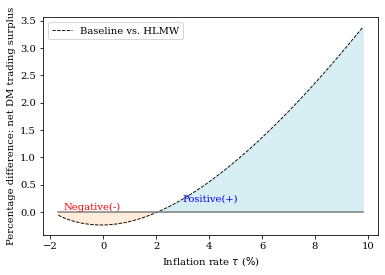

In [32]:
### ZOOM-IN

#τ_cut = 60

τ_cut=-1

plt.plot(τ_grid[0:τ_cut]*100, 
         100.0*(total[0:τ_cut] - total_hlmw[0:τ_cut])/total_hlmw[0:τ_cut],       label='Baseline vs. HLMW',color='black', linestyle='--',linewidth=0.9)
plt.plot(τ_grid[0:τ_cut]*100, np.zeros(total[0:τ_cut].size), color="gray")
plt.ylabel("Percentage difference: net DM trading surplus")
plt.fill_between(τ_grid[0:τ_cut]*100, 100.0*(total[0:τ_cut] - total_hlmw[0:τ_cut])/total_hlmw[0:τ_cut],where=(100.0*(total[0:τ_cut] - total_hlmw[0:τ_cut])/total_hlmw[0:τ_cut] <= 0), color='peachpuff', alpha=0.5, interpolate=True)
plt.fill_between(τ_grid[0:τ_cut]*100, 100.0*(total[0:τ_cut] - total_hlmw[0:τ_cut])/total_hlmw[0:τ_cut],where=(100.0*(total[0:τ_cut] - total_hlmw[0:τ_cut])/total_hlmw[0:τ_cut] >= 0), color='#B0E0E6', alpha=0.5, interpolate=True)
#plt.ylim(-0.1,1.3)
plt.text(-1.5, 0.03, 'Negative(-)',size=10,color='red')
plt.text(3, 0.2, 'Positive(+)',size=10,color='blue')
plt.xlabel(x_string)
plt.legend()
plt.savefig("Money (non-credit) constrained buyers.png", bbox_inches='tight', pad_inches=0.05)
plt.show()


### Decompose: different payment types of buyers

#### Plot the (level) DM net trading surplus (baseline vs. HLMW): for credit-buyers
* Credit buyers: use both own money and loans 
* In HLMW, no credit buyers

### Figure 3: The effects of inflation on Equilibrium Outcome, (a) Credit buyers:

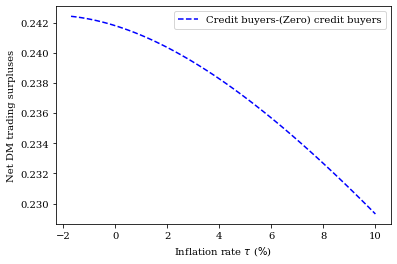

In [33]:
plt.plot(τ_grid*100, np.array(surplus_credit), 
            '--', 
            label='Credit buyers-(Zero) credit buyers',color="blue")
plt.ylabel("Net DM trading surpluses")
plt.xlabel(x_string)
#plt.xlim(-0.5,8)
plt.legend()
plt.savefig("surplus-credit-buyers.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

#### Plot the (level) DM net trading surplus (baseline vs. HLMW): constrained money-buyers
* Only money constrained buyers (baseline)
* Only money constrained buyers (HLMW)

### Figure 3: The effects of inflation on Equilibrium Outcome, (b) Money (non-credit) constrained buyers:

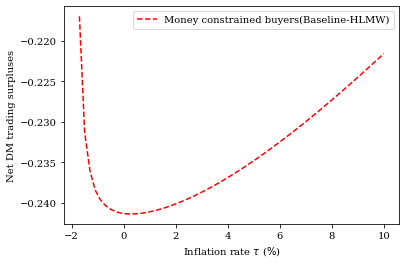

In [34]:
plt.plot(τ_grid*100, np.array(surplus_m_c)-np.array(surplus_c_hlmw),
         '--', 
         label='Money constrained buyers(Baseline-HLMW)',color="red")
plt.ylabel("Net DM trading surpluses")
plt.xlabel(x_string)
plt.legend()
#plt.xlim(-0.5,8)
plt.savefig("surplus-money-constrained-buyers.png", bbox_inches='tight', pad_inches=0.05)
plt.show()

#### Plot the (level) DM net trading surplus (baseline vs. HLMW): unconstrained money-buyers
* Own money unconstrained buyers (baseline)
* Own money unconstrained buyers (HLMW)

### Figure 4: The effects of inflation on Equilibrium Outcome, (c) Money (non-credit) unconstrained buyers

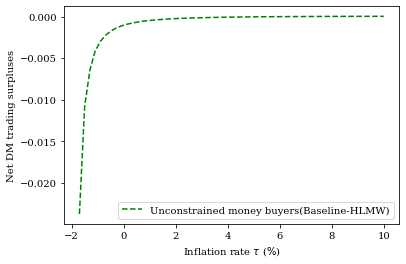

In [35]:
plt.plot(τ_grid*100, np.array(surplus_m_uc)- np.array(surplus_uc_hlmw),
         '--', 
                                label='Unconstrained money buyers(Baseline-HLMW)',color="green")
plt.ylabel("Net DM trading surpluses")
plt.xlabel(x_string)
plt.legend()
#plt.xlim(-0.5,8)
plt.savefig("surplus-money-unconstrained-buyers.png", bbox_inches='tight', pad_inches=0.05)
plt.show()